# **📄 Document type classification baseline code**
> 문서 타입 분류 대회에 오신 여러분 환영합니다! 🎉     
> 아래 baseline에서는 ResNet 모델을 로드하여, 모델을 학습 및 예측 파일 생성하는 프로세스에 대해 알아보겠습니다.

## Contents
- Prepare Environments
- Import Library & Define Functions
- Hyper-parameters
- Load Data
- Train Model
- Inference & Save File


# 소스 참조 : https://dacon.io/codeshare/3658

## 1. Prepare Environments

* 데이터 로드를 위한 구글 드라이브를 마운트합니다.
* 필요한 라이브러리를 설치합니다.

### efficientnet_b5.sw_in12k_ft_in1k
- Model Type: Image classification / feature backbone
- Model Stats:
- Params (M): 30.4
- GMACs: 9.6
- Activations (M): 93.6
- Image size: 448 x 448

### tf_efficientnet_b6.ns_jft_in1k
- Model Type: Image classification / feature backbone
- Model Stats:
- Params (M): 43.0
- GMACs: 19.4
- Activations (M): 167.4
- Image size: 528 x 528

### tf_efficientnet_b7.ns_jft_in1k
- Model Type: Image classification / feature backbone
- Model Stats:
- Params (M): 66.3
- GMACs: 38.3
- Activations (M): 289.9
- Image size: 600 x 600

### vit_base_patch16_clip_384.laion2b_ft_in12k_in1k
- Model Type: Image classification / feature backbone
- Model Stats:
- Params (M): 86.9
- GMACs: 49.4
- Activations (M): 48.3
- Image size: 384 x 384

In [1]:
# 구글 드라이브 마운트, Colab을 이용하지 않는다면 패스해도 됩니다.
#from google.colab import drive
#drive.mount('/gdrive', force_remount=True)
#drive.mount('/content/drive')

In [2]:
# 구글 드라이브에 업로드된 대회 데이터를 압축 해제하고 로컬에 저장합니다.
#!tar -xvf drive/MyDrive/datasets_fin.tar > /dev/null

In [3]:
# 한글 폰트 사용을 위한 라이브러리입니다.
#!apt-get install -y fonts-nanum

In [4]:
# 필요한 라이브러리를 설치합니다.
#!pip install timm

## 2. Import Library & Define Functions
* 학습 및 추론에 필요한 라이브러리를 로드합니다.
* 학습 및 추론에 필요한 함수와 클래스를 정의합니다.

In [5]:
import os
import time
import random

import timm
import torch
import cv2
import glob
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

import time

import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')

from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold
import easydict
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts
from torch.cuda.amp import autocast, GradScaler
import gc
from tensorboardX import SummaryWriter
import ttach as tta
from scipy import stats
from augraphy import *

In [6]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [7]:
# 데이터셋 클래스를 정의합니다.
class ImageDataset(Dataset):
    def __init__(self, csv, path, transform=None):
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        if self.transform:
            img = self.transform(image=img)['image']
        return img, target

In [8]:
# 데이터셋 클래스를 정의합니다.
class ImageDataset2(Dataset):
    def __init__(self, csv, path, transform=None):
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        new_name = name.split('_')
        if len(new_name) > 1:
            path = self.path + new_name[0]  + '/'
            img = np.array(Image.open(os.path.join(path, name)))
        else:
            img = np.array(Image.open(os.path.join(self.path, name)))
        
        if self.transform:
            img = self.transform(image=img)['image']
        return img, target

In [9]:
# 데이터셋 클래스를 정의합니다.
class ImageDataset3(Dataset):
    def __init__(self, path, img_name_list, label_list, transform=None):
        self.img_name_list = img_name_list
        self.label_list = label_list
        self.path = path
        self.transform = transform
        
    def __getitem__(self, idx):
        name = self.img_name_list[idx]
        target = self.label_list[idx]
        new_name = name.split('_')

        if len(new_name) > 1:
            path = self.path + new_name[0]  + '/'
            img = np.array(Image.open(os.path.join(path, name)))
        else:
            img = np.array(Image.open(os.path.join(self.path, name)))

        if self.transform:
            img = self.transform(image=img)['image']

        return img, target
        
    def __len__(self):
        return len(self.img_name_list)

# EDA

In [10]:
train_path = 'data/train.csv'
train_df = pd.read_csv(train_path)

In [11]:
train_df.shape

(1570, 2)

In [12]:
train_df.head()

ID  target
0  002f99746285dfdd.jpg      16
1  008ccd231e1fea5d.jpg      10
2  008f5911bfda7695.jpg      10
3  009235e4c9c07af5.jpg       4
4  00b2f44967580c74.jpg      16

In [13]:
train_df['target'].value_counts()

target
16    100
10    100
0     100
3     100
12    100
8     100
2     100
11    100
7     100
9     100
15    100
5     100
4     100
6     100
13     74
14     50
1      46
Name: count, dtype: int64

In [14]:
doc_type = {
0:'계좌번호',
1:'건강보험 임신/출산 진료비',
2:'자동차계기판',
3:'입퇴원 확인서',
4:'진단서',
5:'자동차운전면허등',
6:'외래비영수증',
7:'통원(진료) 확인서',
8:'주민등록증',
9:'여권',
10:'진료비(약재비) 납입 확인서',
11:'약재비 영수증',
12:'처방전',
13:'이력서',
14:'소견서',
15:'자동차등록증',
16:'자동차번호판'
}


In [15]:
train_df['target'].map(doc_type)

0                자동차번호판
1       진료비(약재비) 납입 확인서
2       진료비(약재비) 납입 확인서
3                   진단서
4                자동차번호판
             ...       
1565                진단서
1566         통원(진료) 확인서
1567            약재비 영수증
1568           자동차운전면허등
1569                 여권
Name: target, Length: 1570, dtype: object

## 잘못 구분된 문서 class 변경

In [16]:
error_dic = [
    ('45f0d2dfc7e47c03.jpg',7),
    ('aec62dced7af97cd.jpg',14),
    ('7100c5c67aecadc5.jpg',7),
    ('8646f2c3280a4f49.jpg',3),
    ('0583254a73b48ece.jpg',10),
    ('1ec14a14bbe633db.jpg',7)
    ]

for id, target in error_dic:
    train_df.loc[train_df['ID'] == id, 'target'] = target  

In [17]:
for id, target in error_dic:
    print(train_df[train_df['ID'] == id])

                       ID  target
428  45f0d2dfc7e47c03.jpg       7
                        ID  target
1095  aec62dced7af97cd.jpg      14
                       ID  target
723  7100c5c67aecadc5.jpg       7
                       ID  target
862  8646f2c3280a4f49.jpg       3
                      ID  target
38  0583254a73b48ece.jpg      10
                       ID  target
192  1ec14a14bbe633db.jpg       7


In [18]:
train_df['target'].value_counts()

target
7     102
10    101
0     100
12    100
8     100
2     100
16    100
9     100
15    100
5     100
4     100
6     100
11     99
3      98
13     74
14     50
1      46
Name: count, dtype: int64

In [19]:
train_df['doc'] = train_df['target'].map(doc_type)
train_df

ID  target              doc
0     002f99746285dfdd.jpg      16           자동차번호판
1     008ccd231e1fea5d.jpg      10  진료비(약재비) 납입 확인서
2     008f5911bfda7695.jpg      10  진료비(약재비) 납입 확인서
3     009235e4c9c07af5.jpg       4              진단서
4     00b2f44967580c74.jpg      16           자동차번호판
...                    ...     ...              ...
1565  fed9e9ec4a77bc06.jpg       4              진단서
1566  feeade617aa68c45.jpg       7       통원(진료) 확인서
1567  ff51dd281a8423f1.jpg      11          약재비 영수증
1568  ff8a6a251ce51c95.jpg       5         자동차운전면허등
1569  ffc22136f958deb1.jpg       9               여권

[1570 rows x 3 columns]

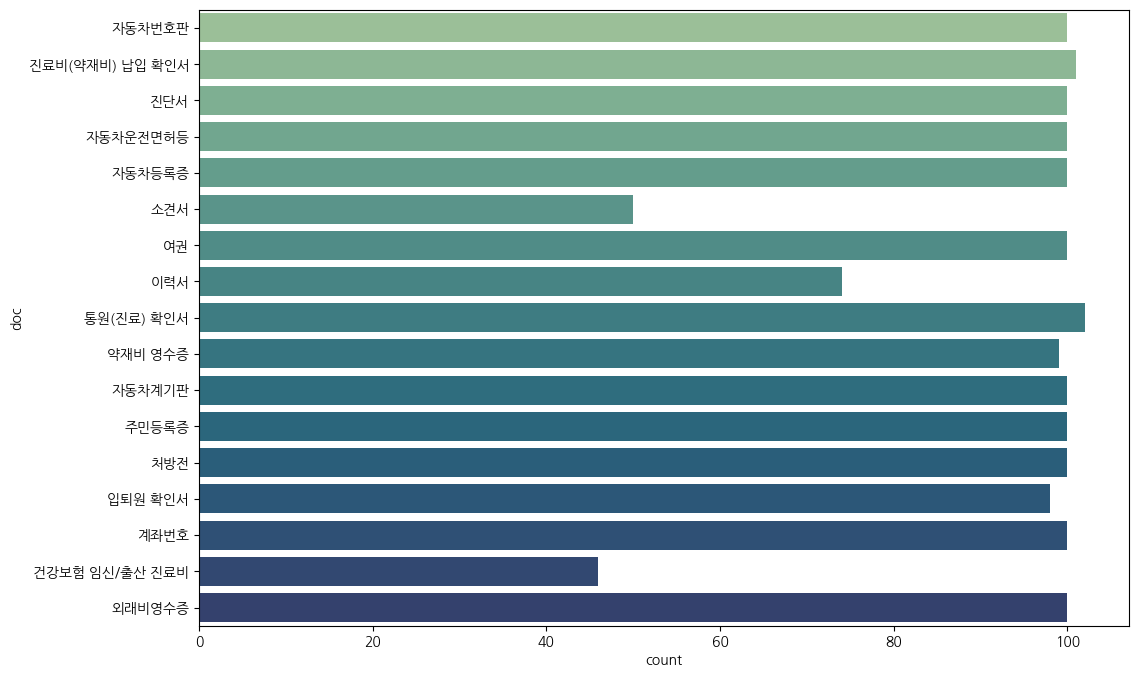

In [20]:
plt.figure(figsize=(12,8))
#sns.countplot(data=train_df, y='target',  palette='crest', dodge=False)
sns.countplot(data=train_df, y='doc',  palette='crest', dodge=False)
plt.show()

In [21]:
train_df.iloc[0]['doc']

'자동차번호판'

In [22]:
def plot_images(df, label, dataset):
    plt.figure(figsize = (4,4))
    species_df = df[df['target'] == label]
    plt.suptitle(f"{species_df.iloc[0]['doc']} : {label}")
    for idx, i in enumerate(np.random.choice(species_df['ID'], 1)):
        plt.subplot(1,1,idx+1)
        image_path = 'data/' + dataset + '/' + i
        img = Image.open(image_path)
        img = img.resize((448,448))
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

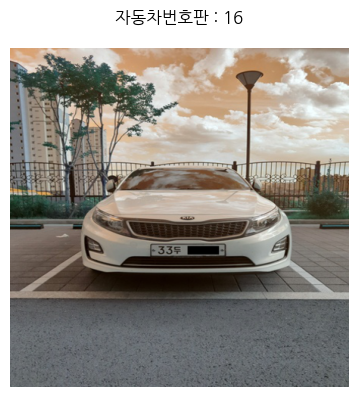

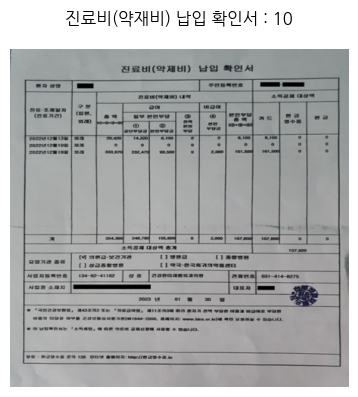

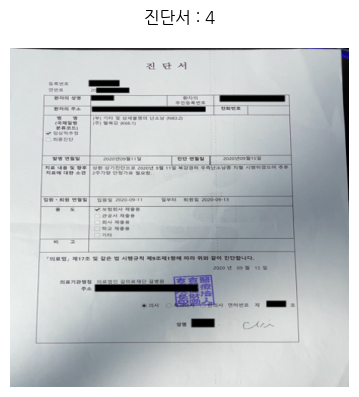

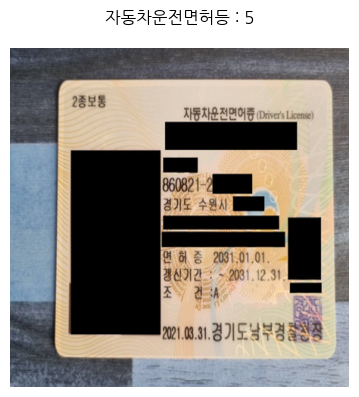

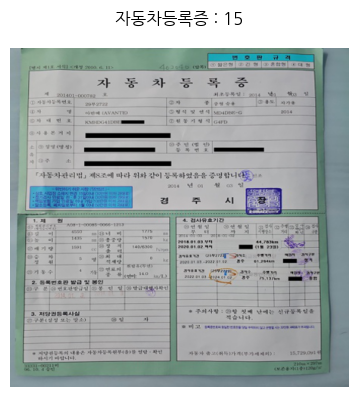

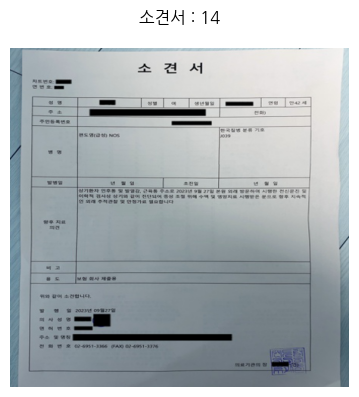

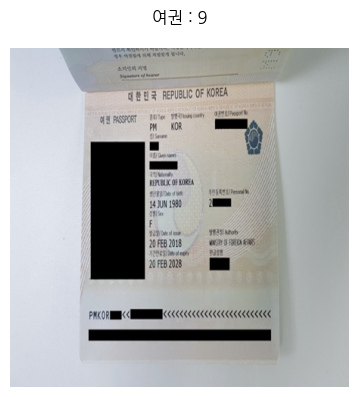

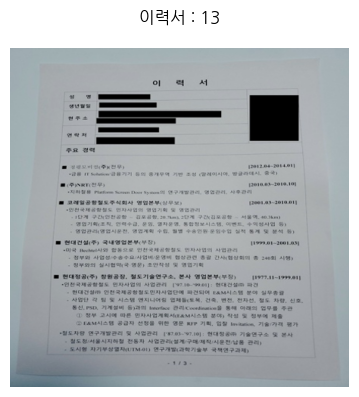

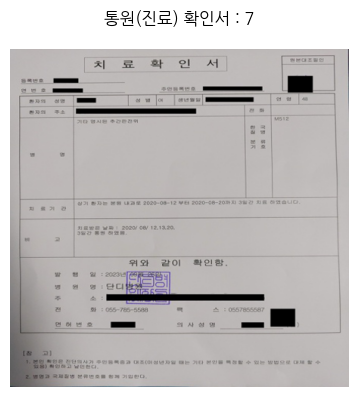

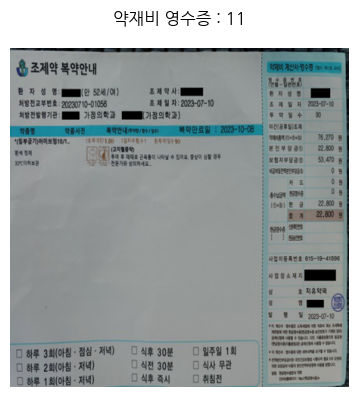

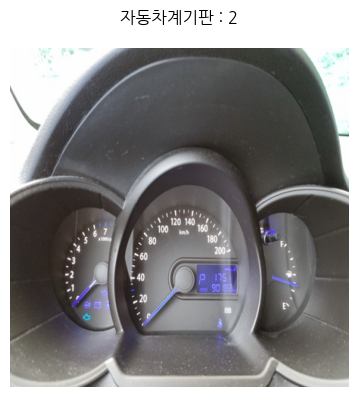

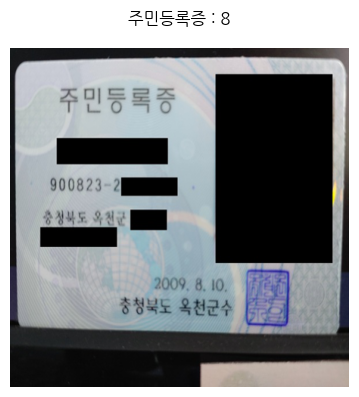

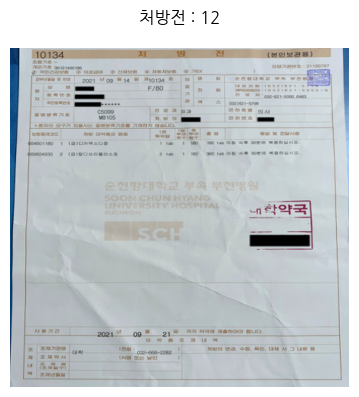

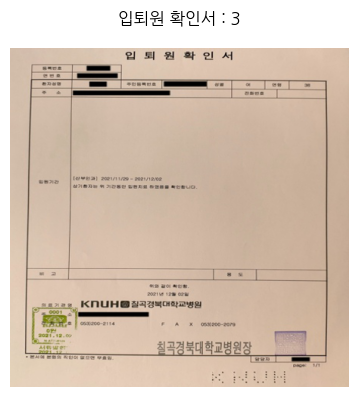

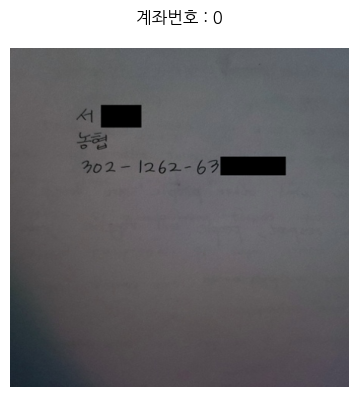

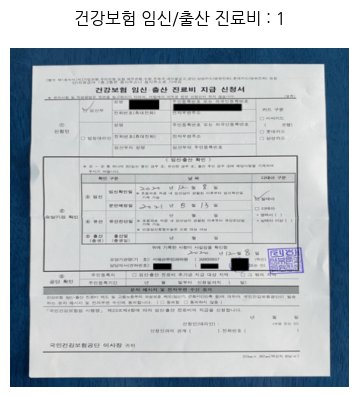

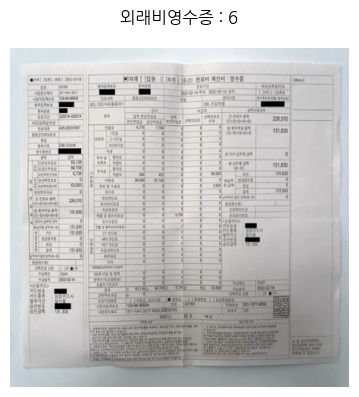

In [23]:
for la in train_df['target'].unique():
    plot_images(train_df , label=la, dataset= 'train')

# Augmentation

In [24]:
def make_aug_data(df, repeat, interval, img_cnt):
    for cat in df['target'].unique():
        # cat.astype(str)
        # print(cat)
        tgt_path = f'data/train/{cat}/'
        org_path = f'data/train/'
        os.makedirs(tgt_path, exist_ok=True)
        print(cat, org_path, org_path)

        #if cat != 3:
        #    continue
        
        new_img_cnt = img_cnt - df[df['target']==cat].shape[0]
                    
        idx = 0
        count = 0

        for file in tqdm(df[df['target']==cat]['ID']):
            for i in range(repeat):
                idx += 1
                org_name = org_path + file
                tgt_name = tgt_path + file
                print(cat, org_name, tgt_name, f"{tgt_path}{i}_{file}")
                image = cv2.imread(org_name)

                train_augraphy = AugraphyPipeline([ShadowCast(shadow_opacity_range=(0,0.35)), LightingGradient(), LowLightNoise(p = 0.5)])
                if idx % interval == 0:
                    image = train_augraphy(image)

                aug = A.Compose([A.VerticalFlip(),
                                A.Rotate(p=1), 
                                A.HorizontalFlip(), 
                                A.RandomBrightnessContrast(brightness_limit=0.2), 
                                A.OneOf([A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=(15, 25)),A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=(-15, -25))], p=0.3),
                                A.GaussianBlur(always_apply=False, p=1.0, blur_limit=(1, 9), sigma_limit=(0, 6.91)),
                                A.PixelDropout(always_apply=False, p=1.0, dropout_prob=0.1, per_channel=0, drop_value=(63, 195, 160), mask_drop_value=None),
                                #A.AdvancedBlur(),
                                #A.ColorJitter(), # Ok
                                #A.GaussNoise(), # Ok
                                #A.OpticalDistortion(distort_limit=(-0.3, 0.3), shift_limit=0.5, p=0.5),
                                #A.Affine(scale=(0.9, 2), translate_percent=(-0.1, 0.1), rotate=(-10, 10), shear=(-20,20)),
                                #A.ElasticTransform(alpha=300), # 제외
                                #A.Resize(400,400)
                                ]) # (300,300)

                image_aug = aug(image=image)['image']
                cv2.imwrite(f"{tgt_path}{cat}_{i}_{file}", image_aug)  ### augmentation 2번 시행할 때 'i'로 구분하지 않으면 덮어씌어짐

                count += 1
                if count > new_img_cnt:
                    break
            if count > new_img_cnt:
                break


if os.path.exists('data/train/1/') == False:
    make_aug_data(train_df, 10, 2, 500)
#make_aug_data(train_df, 10, 2, 500)

In [25]:
train_aug = pd.DataFrame({'path':glob.glob('data/train/*/*')})
train_aug['target'] = train_aug['path'].apply(lambda x: x.split('/')[2])
train_aug['ID'] = train_aug['path'].apply(lambda x: x.split('/')[-1])
train_aug = train_aug[['ID','target']]
train_aug

ID target
0     5_6_4df2ec93065a5c5b.jpg      5
1     5_2_4e038b45aa1e5324.jpg      5
2     5_1_3a4d4dfe70377fd1.jpg      5
3     5_2_31403802398458b2.jpg      5
4     5_2_42768ff4b8ca25a1.jpg      5
...                        ...    ...
6942  9_6_3ebfa49cd84331d7.jpg      9
6943  9_0_3aa71b5ec5630ae9.jpg      9
6944  9_0_4f251e4f50e1b033.jpg      9
6945  9_2_62d8b41419418098.jpg      9
6946  9_3_37a581964c5dd537.jpg      9

[6947 rows x 2 columns]

In [26]:
train_df = pd.concat([train_df, train_aug])
train_df.shape

(8517, 3)

In [27]:
train_df[['ID','target']].to_csv('data/new_train.csv', index=False)

## 3. Hyper-parameters
* 학습 및 추론에 필요한 하이퍼파라미터들을 정의합니다.

In [28]:
# 사용 가능 모델 검색
pretrained_model_list = timm.list_models(pretrained=True)

for model in pretrained_model_list:
    print(model)

bat_resnext26ts.ch_in1k
beit_base_patch16_224.in22k_ft_in22k
beit_base_patch16_224.in22k_ft_in22k_in1k
beit_base_patch16_384.in22k_ft_in22k_in1k
beit_large_patch16_224.in22k_ft_in22k
beit_large_patch16_224.in22k_ft_in22k_in1k
beit_large_patch16_384.in22k_ft_in22k_in1k
beit_large_patch16_512.in22k_ft_in22k_in1k
beitv2_base_patch16_224.in1k_ft_in1k
beitv2_base_patch16_224.in1k_ft_in22k
beitv2_base_patch16_224.in1k_ft_in22k_in1k
beitv2_large_patch16_224.in1k_ft_in1k
beitv2_large_patch16_224.in1k_ft_in22k
beitv2_large_patch16_224.in1k_ft_in22k_in1k
botnet26t_256.c1_in1k
caformer_b36.sail_in1k
caformer_b36.sail_in1k_384
caformer_b36.sail_in22k
caformer_b36.sail_in22k_ft_in1k
caformer_b36.sail_in22k_ft_in1k_384
caformer_m36.sail_in1k
caformer_m36.sail_in1k_384
caformer_m36.sail_in22k
caformer_m36.sail_in22k_ft_in1k
caformer_m36.sail_in22k_ft_in1k_384
caformer_s18.sail_in1k
caformer_s18.sail_in1k_384
caformer_s18.sail_in22k
caformer_s18.sail_in22k_ft_in1k
caformer_s18.sail_in22k_ft_in1k_384
c

In [29]:
# 특정 사용 가능 모델 검색
model_type = 'efficientnet_*' # *resnet*, efficientnet_*
resnet_model_list = timm.list_models(model_type, pretrained=True)
for model in resnet_model_list:
    print(model)

efficientnet_b0.ra_in1k
efficientnet_b1.ft_in1k
efficientnet_b1_pruned.in1k
efficientnet_b2.ra_in1k
efficientnet_b2_pruned.in1k
efficientnet_b3.ra2_in1k
efficientnet_b3_pruned.in1k
efficientnet_b4.ra2_in1k
efficientnet_b5.sw_in12k
efficientnet_b5.sw_in12k_ft_in1k
efficientnet_el.ra_in1k
efficientnet_el_pruned.in1k
efficientnet_em.ra2_in1k
efficientnet_es.ra_in1k
efficientnet_es_pruned.in1k
efficientnet_lite0.ra_in1k


In [30]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data config
data_path = 'data/'

# model config
# 모델 인지하지 못함 : efficientnet-b0, efficientnet-b8 
# 모델 인지함 : resnet34, resnet50, efficientnet_b5

#model_name = 'resnet34' # 'resnet50' 'efficientnet-b0', 'efficientnet-b8'...
model_name = 'efficientnet_b5'

# training config
config = {}

config["seed"] = 42

config["device"] = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config["num_GPU"] = 6 # RTX 3090 GPU 수 6개
config["num_workers"] = 4 * 6
config["pin_memory"] = True

# efficientnet_b5, tf_efficientnet_b6.ns_jft_in1k, tf_efficientnet_b7.ns_jft_in1k, vit_base_patch16_clip_384.laion2b_ft_in12k_in1k
config["model"] = "tf_efficientnet_b6.ns_jft_in1k"
config["load"] = ""
config["n_epochs"] = 50
config["batch_size"] = 16 # 32
config["lr"] = 1e-5
config["class_weight"] = True

config["class_n"] = 17 #len(train_total['disease_code'].unique())
# efficientnet_b5.sw_in12k_ft_in1k : 448 * 448, 
# tf_efficientnet_b6.ns_jft_in1k : 528 * 528
# tf_efficientnet_b7.ns_jft_in1k : 600 * 600
# vit_base_patch16_clip_384.laion2b_ft_in12k_in1k : 384 * 384

config["image_size"] = 528    

config["kfolds"] = 5
config["single_fold"] = False
config["optimizer"] = "adamp"
config["scheduler"] = "reducelr" #"reducelr" 
config["T_0"] = 10
config["min_lr"] = 1e-5
config["log_steps"] = 10
config["patience"] = 10 # 15

config["psuedo_labeling"] = False
config["psuedo_iter_n"] = 1 # 3


args = easydict.EasyDict(config)

img_size = 300 # 32, 224(정상), 300(), 368 (CUDA out of memory)
LR = 1e-3
EPOCHS = 60
BATCH_SIZE = 32
num_GPU = 6 # RTX 3090 GPU 수 6개
num_workers = 4 * num_GPU

## 4. Load Data
* 학습, 테스트 데이터셋과 로더를 정의합니다.

In [31]:
# augmentation을 위한 transform 코드
trn_transform = A.Compose([
    # Augmentation  추가
    A.AdvancedBlur(),
    A.ColorJitter(),
    A.GaussNoise(),
    A.OpticalDistortion(distort_limit=(-0.3, 0.3), shift_limit=0.5, p=0.5),
    A.Affine(scale=(0.9, 2), translate_percent=(-0.1, 0.1), rotate=(-10, 10), shear=(-20,20)),
    A.HorizontalFlip(),
    A.ElasticTransform(alpha=300), # 제외함
    #A.Cutout(always_apply=True), # 추가 19:11, PB 점수가 0.8065에서 0.7699로 낮아짐
    #A.GaussianBlur(always_apply=False, p=1.0, blur_limit=(1, 11), sigma_limit=(0, 6.91)), # 추가 16:35
    #A.PixelDropout(always_apply=False, p=1.0, dropout_prob=0.1, per_channel=0, drop_value=(63, 195, 160), mask_drop_value=None), # 추가 16:35
    # 이미지 크기 조정
    A.Resize(height=args.image_size, width=args.image_size),
    # images normalization
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # numpy 이미지나 PIL 이미지를 PyTorch 텐서로 변환
    ToTensorV2(),
])

# trn_transform = A.Compose([
#     A.Resize(height=args.image_size, width=args.image_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     ToTensorV2(),
# ])

#trn_transform = A.Compose([AugMix(width=3, depth=2, alpha=.2, p=1., augmentations=trn_transform),])

# test image 변환을 위한 transform 코드
tst_transform = A.Compose([
    A.Resize(height=args.image_size, width=args.image_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

In [32]:
# Dataset 정의
tst_dataset = ImageDataset(
    "data/sample_submission.csv",
    "data/test/",
    transform=tst_transform
)
print(len(tst_dataset))

tst_loader = DataLoader(
    tst_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

3140


In [33]:
# one epoch 학습을 위한 함수입니다.
def train_one_epoch(loader, model, optimizer, scaler, loss_fn, device):
    torch.cuda.empty_cache()
    gc.collect()

    model.train()
    train_loss = 0
    preds_list = []
    targets_list = []

    pbar = tqdm(loader)
    for image, targets in pbar:
        image = image.to(device)
        targets = targets.to(device)

        model.zero_grad(set_to_none=True)

        # AMP : autocast를 통한 자동 FP32 -> FP16 변환 (가능한 연산에 한하여)
        with autocast():
            preds = model(image.float())
            loss = loss_fn(preds, targets)

            # AMP : scaled loss를 이용해 backward 진행 (gradient 모두 같은 scale factor로 scale됨)
            # AMP : backward pass는 autocast 영역 내에 진행될 필요 없음
            # AMP : forward pass에서 사용된 같은 data type으로 backward pass는 실행됨            
            scaler.scale(loss).backward()

            # AMP : scaler.step은 가장 먼저 unscale(grad를 scale factor만큼 나눠기)
            # AMP : weight update 실시, 단 만약 grad 중 infs or NaNs이 있으면 step 스킵됨
            scaler.step(optimizer)

            # AMP : scale factor 업데이트
            scaler.update()
            optimizer.zero_grad()

        train_loss += loss.item()
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

        pbar.set_description(f"Train Loss: {loss.item():.4f}")

    train_loss /= len(loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    ret = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
    }

    #print(f"valid acc: {train_acc:.3f}, macro_f1: {train_f1:.4f}, valid_loss: {train_loss:.3f}\n")        

    return ret

# one epoch 학습을 위한 함수입니다.
def valid_one_epoch(loader, model, loss_fn, device):
    torch.cuda.empty_cache()
    gc.collect()
        
    model.eval()
    valid_loss = 0
    preds_list = []
    targets_list = []    

    with torch.no_grad(): # model의 업데이트 막기    
        pbar = tqdm(loader)
        for image, targets in pbar:
            image = image.to(device)
            targets = targets.to(device)

            preds = model(image)
            loss = loss_fn(preds, targets)
            valid_loss += loss.item()

            preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
            targets_list.extend(targets.detach().cpu().numpy())

            pbar.set_description(f"Valid Loss: {loss.item():.4f}")

        valid_loss /= len(loader)
        valid_acc = accuracy_score(targets_list, preds_list)
        valid_f1 = f1_score(targets_list, preds_list, average='macro')

        ret = {
            "valid_loss": valid_loss,
            "valid_acc": valid_acc,
            "valid_f1": valid_f1,
        }

    #print(f"valid acc: {valid_acc:.3f}, macro_f1: {valid_f1:.4f}, valid_loss: {valid_loss:.3f}\n")        

    return ret    

## 5. Train Model
* 모델을 로드하고, 학습을 진행합니다.

In [34]:
# load model
model = timm.create_model(
    args.model, #model_name,
    pretrained=True,
    num_classes=17
).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [35]:
model.default_cfg

{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b6_ns-51548356.pth',
 'hf_hub_id': 'timm/tf_efficientnet_b6.ns_jft_in1k',
 'architecture': 'tf_efficientnet_b6',
 'tag': 'ns_jft_in1k',
 'custom_load': False,
 'input_size': (3, 528, 528),
 'fixed_input_size': False,
 'interpolation': 'bicubic',
 'crop_pct': 0.942,
 'crop_mode': 'center',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'num_classes': 1000,
 'pool_size': (17, 17),
 'first_conv': 'conv_stem',
 'classifier': 'classifier'}

In [36]:
class Timm(nn.Module):
    def __init__(self, model_name="efficientnet_b5", class_n=config["class_n"]):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=True, num_classes=class_n)
        
    def forward(self, x):
        x = self.model(x)
        return x

In [37]:
def get_model():
    model = Timm(model_name=config["model"]).to(config["device"])
    return model

In [38]:
writer = SummaryWriter()

In [39]:
#%%time
# gpu 소요시간 : 
#for epoch in range(EPOCHS):
#    ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device=device)
#    ret['epoch'] = epoch
#
#    log = ""
#    for k, v in ret.items():
#      log += f"{k}: {v:.4f}\n"
#    print(log)

In [40]:
def get_scheduler(optimizer):
    if config["scheduler"] == "reducelr":
        scheduler = ReduceLROnPlateau(optimizer, patience=5, factor=0.5, mode="max", verbose=True)
    elif config["scheduler"] == "cosineanneal":
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=args.T_0, T_mult=1, eta_min=args.min_lr, last_epoch=-1, verbose=True)
    return scheduler

In [41]:
def run(model, fold, train_df, valid_df, test_df):
    torch.cuda.empty_cache()
    gc.collect()
        
    train_data = ImageDataset3("data/train/", 
                                train_df['ID'].values, 
                                train_df['target'].values, 
                                transform=trn_transform)
    valid_data = ImageDataset3("data/train/", 
                                    valid_df['ID'].values, 
                                    valid_df['target'].values, 
                                    transform=tst_transform)      

    train_len = len(train_data)
    valid_len = len(valid_data)
    #print(f'train : {train_len}, valid : {valid_len}')

    train_dataloader =  DataLoader(train_data,
                          batch_size=args.batch_size,
                          shuffle=True,
                          num_workers=args.num_workers,
                          pin_memory=True,    
                          drop_last=False)

    valid_dataloader = DataLoader(valid_data,
                            batch_size=args.batch_size,
                            shuffle=False,
                            num_workers=args.num_workers,
                            pin_memory=True,
                            drop_last=False)

    #model = get_model()    
    scheduler = get_scheduler(optimizer)
    scaler = GradScaler()
    
    early_stopping_counter = 0
    best_acc =-1
    best_f1 = -1
    best_loss = float("inf")
    if config["psuedo_labeling"]:
        iter_n = config["psuedo_iter_n"]
    else:
        iter_n = 1    

    train_loss_array = []
    train_acc_array = []
    train_f1_array = []
    val_loss_array = []
    val_acc_array = []
    val_f1_array = []

    for iter_i in range(iter_n):
        for epoch in range(args.n_epochs):
            print(f"Epoch {epoch + 1}/{args.n_epochs}")
            
            #train(model, train_dataloader, optimizer, scaler, epoch)
            train_ret = train_one_epoch(train_dataloader, model, optimizer, scaler, loss_fn, device)
            
            #valid_acc, valid_f1, valid_loss = validate(model, val_dataloader)
            valid_ret = valid_one_epoch(valid_dataloader, model, loss_fn, device) 

            log = "\n"
            for k, v in train_ret.items():
                log += f"{k}: {v:.4f} "
            for k, v in valid_ret.items():
                log += f"{k}: {v:.4f} "       
            print(log)      

            writer.add_scalar(f"{fold + 1} Train loss", train_ret['train_loss'], (epoch + 1))
            writer.add_scalar(f"{fold + 1} Train acc", train_ret['train_acc'], (epoch + 1))
            writer.add_scalar(f"{fold + 1} Train f1", train_ret['train_f1'], (epoch + 1))

            writer.add_scalar(f"{fold + 1} Valid loss", valid_ret['valid_loss'], (epoch + 1))
            writer.add_scalar(f"{fold + 1} Valid acc", valid_ret['valid_acc'], (epoch + 1))
            writer.add_scalar(f"{fold + 1} Valid f1", valid_ret['valid_f1'], (epoch + 1))

            writer.flush()

            train_loss_array.append(train_ret['train_loss'])
            train_acc_array.append(train_ret['train_acc'])
            train_f1_array.append(train_ret['train_f1'])
            val_loss_array.append(valid_ret['valid_loss'])
            val_acc_array.append(valid_ret['valid_acc'])
            val_f1_array.append(valid_ret['valid_f1'])

            score = {
                'epoch' : epoch,
                'train_loss' : train_loss_array,
                'train_acc' : train_acc_array,
                'train_f1' : train_f1_array,
                'valid_loss' : val_loss_array,
                'valid_acc' : val_acc_array,
                'valid_f1' : val_f1_array                
            }             

            valid_f1 = valid_ret['valid_f1']
            valid_loss = valid_ret['valid_loss']

            if valid_f1 > best_f1:
                best_f1 = valid_f1
                early_stopping_counter = 0    

                save_name = f"{args.model}_fold{fold}_{str(best_f1)[:5]}.pth"
                save_root_dir = f"results/{args.model}"     

                if not os.path.exists(save_root_dir):
                    os.makedirs(save_root_dir, exist_ok=True)
                
                torch.save(model, os.path.join(save_root_dir, save_name))
                print(f"model saved! {save_name}")

            elif valid_f1 == best_f1 and valid_loss < best_loss:
                best_loss = valid_loss
                early_stopping_counter = 0
                
                save_name = f"{args.model}_fold{fold}_{str(best_f1)[:5]}.pth"
                save_root_dir = f"results/{args.model}"
                
                if not os.path.exists(save_root_dir):
                    os.makedirs(save_root_dir, exist_ok=True)
                
                torch.save(model, os.path.join(save_root_dir, save_name))
                print(f"model saved! {save_name}")  
            else:
                early_stopping_counter += 1
                if early_stopping_counter >= args.patience:
                    print(f"Early Stopping counter: {early_stopping_counter} out of {args.patience}")
                    
                    # save_best_model
                    model = torch.load(os.path.join(save_root_dir, save_name))
                    save_name = f"best_model_{fold}.pth"
                    torch.save(model, os.path.join(save_root_dir, save_name))

                    return os.path.join(save_root_dir, save_name), log, score
                
            if valid_loss < best_loss:
                best_loss = valid_loss
                print(f"best loss update {best_loss:.4f}")
            
            if args.scheduler == "cosineanneal":
                scheduler.step()
            elif args.scheduler == "reducelr":
                scheduler.step(best_f1)       

    # save_best_model
    model = torch.load(os.path.join(save_root_dir, save_name))
    save_name = f"best_model_{fold}.pth"
    torch.save(model, os.path.join(save_root_dir, save_name))
    
    return os.path.join(save_root_dir, save_name), log, score

In [42]:
def plot_cm(model_path, train_df, valid_df):
    torch.cuda.empty_cache()
    gc.collect()
    
    train_data = ImageDataset3("data/train/", 
                                train_df['ID'].values, 
                                train_df['target'].values, 
                                transform=trn_transform)
    valid_data = ImageDataset3("data/train/", 
                                    valid_df['ID'].values, 
                                    valid_df['target'].values, 
                                    transform=tst_transform)      

    train_dataloader =  DataLoader(train_data,
                          batch_size=args.batch_size,
                          shuffle=True,
                          num_workers=args.num_workers,
                          pin_memory=True,    
                          drop_last=False)

    valid_dataloader = DataLoader(valid_data,
                            batch_size=args.batch_size,
                            shuffle=False,
                            num_workers=args.num_workers,
                            pin_memory=True,
                            drop_last=False)

    model = torch.load(model_path).to(config["device"])
    model.eval()
    
    ## train
    y_pred = []
    y_test = []

    with torch.no_grad(): # model의 업데이트 막기    
        pbar = tqdm(train_dataloader)
        for image, targets in pbar:
            image = image.to(device)
            targets = targets.to(device)    

            preds = model(image)
            y_pred.extend(preds.argmax(dim=1).detach().cpu().numpy())
            y_test.extend(targets.detach().cpu().numpy())            

    # Creates a confusion matrix
    cm = confusion_matrix(y_test, y_pred) 

    # Transform to df for easier plotting
    cm_df = pd.DataFrame(cm,
                         index = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16'], 
                         columns = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16'])

    plt.figure(figsize=(8,8))
    sns.heatmap(cm_df, annot=True)
    plt.title('Train Evaluate \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred)))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    ## valid
    y_pred = []
    y_test = []
    
    with torch.no_grad(): # model의 업데이트 막기    
        pbar = tqdm(valid_dataloader)
        for image, targets in pbar:
            image = image.to(device)
            targets = targets.to(device)    

            preds = model(image)
            y_pred.extend(preds.argmax(dim=1).detach().cpu().numpy())
            y_test.extend(targets.detach().cpu().numpy())  
    
    # Creates a confusion matrix
    cm = confusion_matrix(y_test, y_pred) 

    # Transform to df for easier plotting
    cm_df = pd.DataFrame(cm,
                         index = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16'], 
                         columns = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16'])

    plt.figure(figsize=(8,8))
    sns.heatmap(cm_df, annot=True, cmap=plt.cm.Blues, fmt='g')
    plt.title('Valid Evaluate \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred)))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [43]:
def visualize_training_results(train_loss_array,
                               val_loss_array,
                               train_acc_array,
                               val_acc_array,
                               train_f1_array,
                               val_f1_array,                               
                               num_epochs,
                               fold):
    fig, axs = plt.subplots(3, 1, figsize=(12,9))
    fig.suptitle("{} fold | {} training | Batch size: {}".format(fold, args.model, args.batch_size), fontsize = 16)
    axs[0].plot(list(range(1, num_epochs+1)), train_loss_array, label="train_loss")
    axs[0].plot(list(range(1, num_epochs+1)), val_loss_array, label="val_loss")
    axs[0].legend(loc='best')
    axs[0].set(xlabel='epochs', ylabel='loss')

    axs[1].plot(list(range(1, num_epochs+1)), train_acc_array, label="train_acc")
    axs[1].plot(list(range(1, num_epochs+1)), val_acc_array, label="val_acc")
    axs[1].legend(loc='best')
    axs[1].set(xlabel='epochs', ylabel='accuracy')    

    axs[2].plot(list(range(1, num_epochs+1)), train_f1_array, label="train_f1")
    axs[2].plot(list(range(1, num_epochs+1)), val_f1_array, label="val_f1")
    axs[2].legend(loc='best')
    axs[2].set(xlabel='epochs', ylabel='f1')    
    plt.show()

In [44]:
train_total = pd.read_csv("data/new_train.csv")
test = pd.read_csv("data/sample_submission.csv")
train_total['target'].value_counts()
#print(train_total.shape)

target
16    501
11    501
1     501
0     501
3     501
12    501
8     501
2     501
7     501
10    501
13    501
9     501
14    501
15    501
5     501
4     501
6     501
Name: count, dtype: int64

Epoch 1/50


  0%|          | 0/426 [00:00<?, ?it/s]

Valid Loss: 0.0293: 100%|██████████| 107/107 [00:18<00:00,  5.85it/s]



train_loss: 1.0465 train_acc: 0.6599 train_f1: 0.6580 valid_loss: 0.4477 valid_acc: 0.8433 valid_f1: 0.8317 
model saved! tf_efficientnet_b6.ns_jft_in1k_fold0_0.831.pth
best loss update 0.4477
Epoch 2/50


Valid Loss: 0.0258: 100%|██████████| 107/107 [00:16<00:00,  6.34it/s]



train_loss: 0.5963 train_acc: 0.7938 train_f1: 0.7923 valid_loss: 0.2545 valid_acc: 0.9114 valid_f1: 0.9063 
model saved! tf_efficientnet_b6.ns_jft_in1k_fold0_0.906.pth
best loss update 0.2545
Epoch 3/50


Valid Loss: 0.0046: 100%|██████████| 107/107 [00:17<00:00,  6.28it/s]



train_loss: 0.4665 train_acc: 0.8369 train_f1: 0.8362 valid_loss: 0.3975 valid_acc: 0.8580 valid_f1: 0.8533 
Epoch 4/50


Valid Loss: 0.0008: 100%|██████████| 107/107 [00:17<00:00,  6.23it/s]



train_loss: 0.3986 train_acc: 0.8628 train_f1: 0.8621 valid_loss: 0.2266 valid_acc: 0.9243 valid_f1: 0.9234 
model saved! tf_efficientnet_b6.ns_jft_in1k_fold0_0.923.pth
best loss update 0.2266
Epoch 5/50


Valid Loss: 0.0004: 100%|██████████| 107/107 [00:17<00:00,  6.23it/s]



train_loss: 0.3353 train_acc: 0.8836 train_f1: 0.8833 valid_loss: 0.1749 valid_acc: 0.9325 valid_f1: 0.9336 
model saved! tf_efficientnet_b6.ns_jft_in1k_fold0_0.933.pth
best loss update 0.1749
Epoch 6/50


Valid Loss: 0.4428: 100%|██████████| 107/107 [00:16<00:00,  6.30it/s]



train_loss: 0.3287 train_acc: 0.8874 train_f1: 0.8870 valid_loss: 0.1886 valid_acc: 0.9296 valid_f1: 0.9301 
Epoch 7/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.26it/s]



train_loss: 0.3014 train_acc: 0.8956 train_f1: 0.8953 valid_loss: 0.1133 valid_acc: 0.9566 valid_f1: 0.9562 
model saved! tf_efficientnet_b6.ns_jft_in1k_fold0_0.956.pth
best loss update 0.1133
Epoch 8/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.26it/s]



train_loss: 0.2719 train_acc: 0.9077 train_f1: 0.9075 valid_loss: 0.1100 valid_acc: 0.9577 valid_f1: 0.9575 
model saved! tf_efficientnet_b6.ns_jft_in1k_fold0_0.957.pth
best loss update 0.1100
Epoch 9/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:16<00:00,  6.30it/s]



train_loss: 0.2399 train_acc: 0.9197 train_f1: 0.9195 valid_loss: 0.1135 valid_acc: 0.9566 valid_f1: 0.9571 
Epoch 10/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.21it/s]



train_loss: 0.2340 train_acc: 0.9218 train_f1: 0.9217 valid_loss: 0.0970 valid_acc: 0.9654 valid_f1: 0.9650 
model saved! tf_efficientnet_b6.ns_jft_in1k_fold0_0.965.pth
best loss update 0.0970
Epoch 11/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.23it/s]



train_loss: 0.2241 train_acc: 0.9268 train_f1: 0.9267 valid_loss: 0.0884 valid_acc: 0.9630 valid_f1: 0.9626 
best loss update 0.0884
Epoch 12/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:16<00:00,  6.33it/s]



train_loss: 0.1989 train_acc: 0.9347 train_f1: 0.9345 valid_loss: 0.0865 valid_acc: 0.9712 valid_f1: 0.9711 
model saved! tf_efficientnet_b6.ns_jft_in1k_fold0_0.971.pth
best loss update 0.0865
Epoch 13/50


Valid Loss: 0.0003: 100%|██████████| 107/107 [00:17<00:00,  6.23it/s]



train_loss: 0.1952 train_acc: 0.9403 train_f1: 0.9402 valid_loss: 0.0916 valid_acc: 0.9665 valid_f1: 0.9664 
Epoch 14/50


Valid Loss: 0.0035: 100%|██████████| 107/107 [00:16<00:00,  6.30it/s]



train_loss: 0.1988 train_acc: 0.9344 train_f1: 0.9342 valid_loss: 0.1069 valid_acc: 0.9683 valid_f1: 0.9680 
Epoch 15/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.21it/s]



train_loss: 0.1897 train_acc: 0.9385 train_f1: 0.9384 valid_loss: 0.0552 valid_acc: 0.9830 valid_f1: 0.9829 
model saved! tf_efficientnet_b6.ns_jft_in1k_fold0_0.982.pth
best loss update 0.0552
Epoch 16/50


Valid Loss: 0.0002: 100%|██████████| 107/107 [00:16<00:00,  6.33it/s]



train_loss: 0.1785 train_acc: 0.9422 train_f1: 0.9421 valid_loss: 0.0773 valid_acc: 0.9748 valid_f1: 0.9746 
Epoch 17/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.27it/s]



train_loss: 0.1526 train_acc: 0.9479 train_f1: 0.9478 valid_loss: 0.0448 valid_acc: 0.9859 valid_f1: 0.9859 
model saved! tf_efficientnet_b6.ns_jft_in1k_fold0_0.985.pth
best loss update 0.0448
Epoch 18/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.23it/s]



train_loss: 0.1612 train_acc: 0.9461 train_f1: 0.9461 valid_loss: 0.0721 valid_acc: 0.9765 valid_f1: 0.9764 
Epoch 19/50


Valid Loss: 0.0001: 100%|██████████| 107/107 [00:17<00:00,  6.27it/s]



train_loss: 0.1504 train_acc: 0.9479 train_f1: 0.9478 valid_loss: 0.0600 valid_acc: 0.9806 valid_f1: 0.9807 
Epoch 20/50


Valid Loss: 0.0001: 100%|██████████| 107/107 [00:17<00:00,  6.20it/s]



train_loss: 0.1461 train_acc: 0.9514 train_f1: 0.9514 valid_loss: 0.0580 valid_acc: 0.9812 valid_f1: 0.9813 
Epoch 21/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.20it/s]



train_loss: 0.1386 train_acc: 0.9536 train_f1: 0.9536 valid_loss: 0.0771 valid_acc: 0.9765 valid_f1: 0.9764 
Epoch 22/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.22it/s]



train_loss: 0.1179 train_acc: 0.9593 train_f1: 0.9593 valid_loss: 0.0700 valid_acc: 0.9789 valid_f1: 0.9791 
Epoch 23/50


Valid Loss: 0.0001: 100%|██████████| 107/107 [00:17<00:00,  6.16it/s]



train_loss: 0.1238 train_acc: 0.9611 train_f1: 0.9611 valid_loss: 0.0650 valid_acc: 0.9783 valid_f1: 0.9784 
Epoch 00023: reducing learning rate of group 0 to 5.0000e-04.
Epoch 24/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:16<00:00,  6.33it/s]



train_loss: 0.0780 train_acc: 0.9718 train_f1: 0.9718 valid_loss: 0.0418 valid_acc: 0.9853 valid_f1: 0.9853 
best loss update 0.0418
Epoch 25/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.26it/s]



train_loss: 0.0487 train_acc: 0.9836 train_f1: 0.9836 valid_loss: 0.0447 valid_acc: 0.9888 valid_f1: 0.9888 
model saved! tf_efficientnet_b6.ns_jft_in1k_fold0_0.988.pth
Epoch 26/50


Valid Loss: 0.0013: 100%|██████████| 107/107 [00:17<00:00,  6.27it/s]



train_loss: 0.0604 train_acc: 0.9808 train_f1: 0.9808 valid_loss: 0.0558 valid_acc: 0.9842 valid_f1: 0.9843 
Epoch 27/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.19it/s]



train_loss: 0.0655 train_acc: 0.9784 train_f1: 0.9784 valid_loss: 0.0443 valid_acc: 0.9883 valid_f1: 0.9882 
Epoch 28/50


Valid Loss: 0.0024: 100%|██████████| 107/107 [00:17<00:00,  6.19it/s]



train_loss: 0.0520 train_acc: 0.9840 train_f1: 0.9840 valid_loss: 0.0425 valid_acc: 0.9924 valid_f1: 0.9923 
model saved! tf_efficientnet_b6.ns_jft_in1k_fold0_0.992.pth
Epoch 29/50


Valid Loss: 0.0002: 100%|██████████| 107/107 [00:17<00:00,  6.20it/s]



train_loss: 0.0644 train_acc: 0.9789 train_f1: 0.9788 valid_loss: 0.0469 valid_acc: 0.9906 valid_f1: 0.9906 
Epoch 30/50


Valid Loss: 0.0001: 100%|██████████| 107/107 [00:17<00:00,  6.26it/s]



train_loss: 0.0465 train_acc: 0.9831 train_f1: 0.9831 valid_loss: 0.0465 valid_acc: 0.9888 valid_f1: 0.9888 
Epoch 31/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.19it/s]



train_loss: 0.0621 train_acc: 0.9777 train_f1: 0.9777 valid_loss: 0.0493 valid_acc: 0.9894 valid_f1: 0.9894 
Epoch 32/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:16<00:00,  6.30it/s]



train_loss: 0.0545 train_acc: 0.9819 train_f1: 0.9820 valid_loss: 0.0436 valid_acc: 0.9888 valid_f1: 0.9889 
Epoch 33/50


Valid Loss: 0.0002: 100%|██████████| 107/107 [00:16<00:00,  6.30it/s]



train_loss: 0.0486 train_acc: 0.9858 train_f1: 0.9858 valid_loss: 0.0419 valid_acc: 0.9888 valid_f1: 0.9888 
Epoch 34/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:16<00:00,  6.31it/s]



train_loss: 0.0460 train_acc: 0.9847 train_f1: 0.9847 valid_loss: 0.0406 valid_acc: 0.9906 valid_f1: 0.9906 
best loss update 0.0406
Epoch 00034: reducing learning rate of group 0 to 2.5000e-04.
Epoch 35/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.26it/s]



train_loss: 0.0438 train_acc: 0.9850 train_f1: 0.9850 valid_loss: 0.0314 valid_acc: 0.9906 valid_f1: 0.9905 
best loss update 0.0314
Epoch 36/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.29it/s]



train_loss: 0.0242 train_acc: 0.9921 train_f1: 0.9921 valid_loss: 0.0342 valid_acc: 0.9918 valid_f1: 0.9918 
Epoch 37/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:16<00:00,  6.30it/s]



train_loss: 0.0296 train_acc: 0.9909 train_f1: 0.9909 valid_loss: 0.0440 valid_acc: 0.9924 valid_f1: 0.9923 
model saved! tf_efficientnet_b6.ns_jft_in1k_fold0_0.992.pth
Epoch 38/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.22it/s]



train_loss: 0.0212 train_acc: 0.9927 train_f1: 0.9927 valid_loss: 0.0415 valid_acc: 0.9918 valid_f1: 0.9918 
Epoch 39/50


Valid Loss: 0.0001: 100%|██████████| 107/107 [00:16<00:00,  6.30it/s]



train_loss: 0.0232 train_acc: 0.9927 train_f1: 0.9927 valid_loss: 0.0567 valid_acc: 0.9900 valid_f1: 0.9900 
Epoch 40/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.26it/s]



train_loss: 0.0256 train_acc: 0.9919 train_f1: 0.9919 valid_loss: 0.0531 valid_acc: 0.9900 valid_f1: 0.9900 
Epoch 00040: reducing learning rate of group 0 to 1.2500e-04.
Epoch 41/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.20it/s]



train_loss: 0.0210 train_acc: 0.9919 train_f1: 0.9919 valid_loss: 0.0588 valid_acc: 0.9894 valid_f1: 0.9894 
Epoch 42/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.25it/s]



train_loss: 0.0237 train_acc: 0.9909 train_f1: 0.9909 valid_loss: 0.0369 valid_acc: 0.9924 valid_f1: 0.9924 
model saved! tf_efficientnet_b6.ns_jft_in1k_fold0_0.992.pth
Epoch 43/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:16<00:00,  6.30it/s]



train_loss: 0.0169 train_acc: 0.9938 train_f1: 0.9938 valid_loss: 0.0423 valid_acc: 0.9918 valid_f1: 0.9918 
Epoch 44/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.26it/s]



train_loss: 0.0205 train_acc: 0.9937 train_f1: 0.9937 valid_loss: 0.0491 valid_acc: 0.9906 valid_f1: 0.9906 
Epoch 45/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.23it/s]



train_loss: 0.0151 train_acc: 0.9952 train_f1: 0.9952 valid_loss: 0.0459 valid_acc: 0.9912 valid_f1: 0.9912 
Epoch 46/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.19it/s]



train_loss: 0.0156 train_acc: 0.9949 train_f1: 0.9949 valid_loss: 0.0395 valid_acc: 0.9912 valid_f1: 0.9912 
Epoch 00046: reducing learning rate of group 0 to 6.2500e-05.
Epoch 47/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.25it/s]



train_loss: 0.0152 train_acc: 0.9956 train_f1: 0.9956 valid_loss: 0.0369 valid_acc: 0.9924 valid_f1: 0.9923 
Epoch 48/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:16<00:00,  6.30it/s]



train_loss: 0.0150 train_acc: 0.9954 train_f1: 0.9955 valid_loss: 0.0310 valid_acc: 0.9930 valid_f1: 0.9929 
model saved! tf_efficientnet_b6.ns_jft_in1k_fold0_0.992.pth
best loss update 0.0310
Epoch 49/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.22it/s]



train_loss: 0.0148 train_acc: 0.9952 train_f1: 0.9952 valid_loss: 0.0354 valid_acc: 0.9924 valid_f1: 0.9924 
Epoch 50/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:16<00:00,  6.30it/s]



train_loss: 0.0119 train_acc: 0.9963 train_f1: 0.9963 valid_loss: 0.0320 valid_acc: 0.9935 valid_f1: 0.9935 
model saved! tf_efficientnet_b6.ns_jft_in1k_fold0_0.993.pth


100%|██████████| 426/426 [01:35<00:00,  4.45it/s]


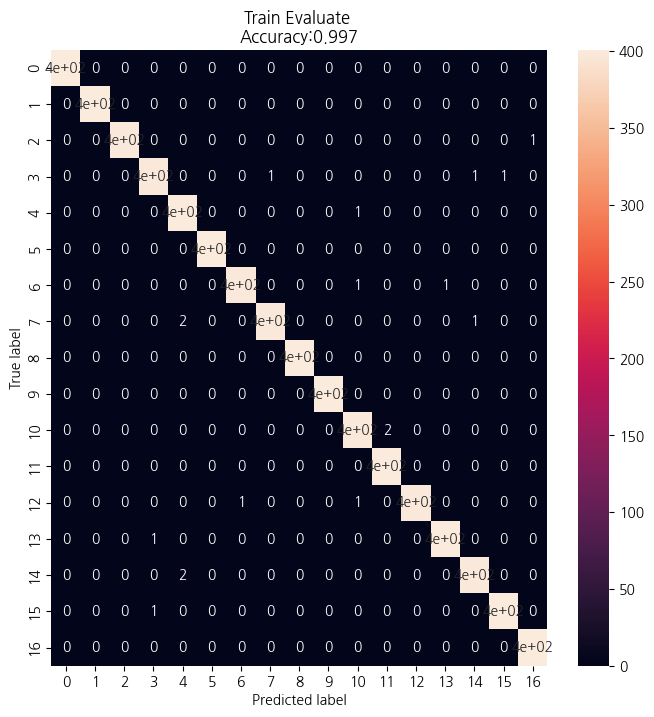

100%|██████████| 107/107 [00:17<00:00,  6.27it/s]


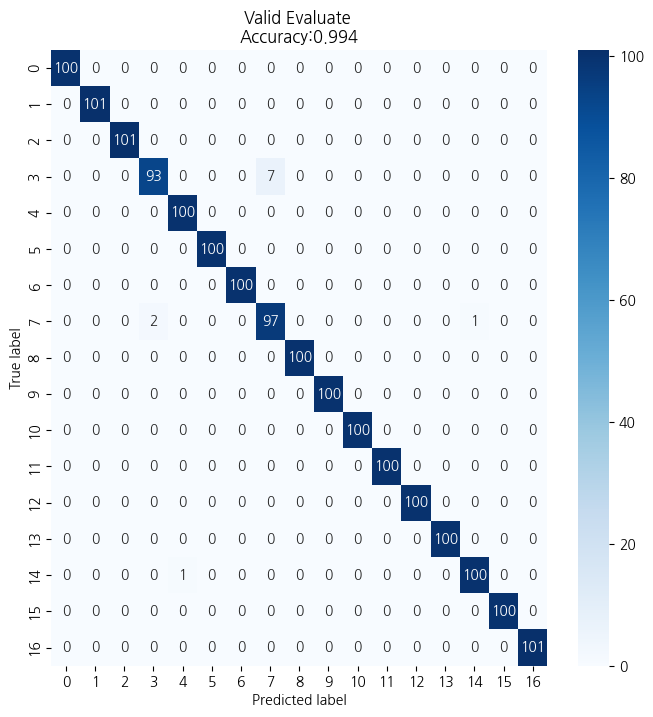

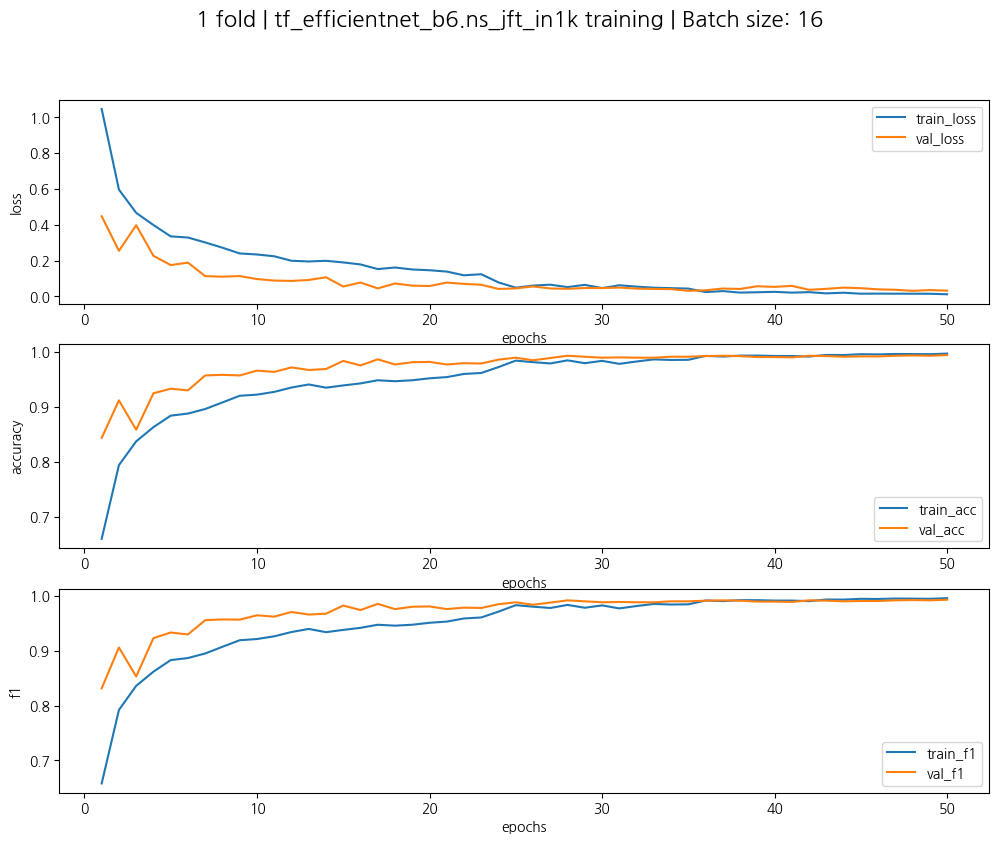

Epoch 1/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.23it/s]



train_loss: 0.0222 train_acc: 0.9941 train_f1: 0.9941 valid_loss: 0.0004 valid_acc: 1.0000 valid_f1: 1.0000 
model saved! tf_efficientnet_b6.ns_jft_in1k_fold1_1.0.pth
best loss update 0.0004
Epoch 2/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.26it/s]



train_loss: 0.0204 train_acc: 0.9940 train_f1: 0.9940 valid_loss: 0.0003 valid_acc: 1.0000 valid_f1: 1.0000 
model saved! tf_efficientnet_b6.ns_jft_in1k_fold1_1.0.pth
Epoch 3/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.26it/s]



train_loss: 0.0166 train_acc: 0.9949 train_f1: 0.9949 valid_loss: 0.0006 valid_acc: 1.0000 valid_f1: 1.0000 
Epoch 4/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.18it/s]



train_loss: 0.0214 train_acc: 0.9928 train_f1: 0.9928 valid_loss: 0.0002 valid_acc: 1.0000 valid_f1: 1.0000 
model saved! tf_efficientnet_b6.ns_jft_in1k_fold1_1.0.pth
Epoch 5/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.29it/s]



train_loss: 0.0171 train_acc: 0.9943 train_f1: 0.9943 valid_loss: 0.0003 valid_acc: 1.0000 valid_f1: 1.0000 
Epoch 6/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.16it/s]



train_loss: 0.0154 train_acc: 0.9960 train_f1: 0.9960 valid_loss: 0.0002 valid_acc: 1.0000 valid_f1: 1.0000 
Epoch 7/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.27it/s]



train_loss: 0.0122 train_acc: 0.9966 train_f1: 0.9966 valid_loss: 0.0002 valid_acc: 1.0000 valid_f1: 1.0000 
Epoch 00007: reducing learning rate of group 0 to 3.1250e-05.
Epoch 8/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.29it/s]



train_loss: 0.0105 train_acc: 0.9965 train_f1: 0.9965 valid_loss: 0.0002 valid_acc: 1.0000 valid_f1: 1.0000 
Epoch 9/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.21it/s]



train_loss: 0.0123 train_acc: 0.9959 train_f1: 0.9959 valid_loss: 0.0002 valid_acc: 1.0000 valid_f1: 1.0000 
Epoch 10/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.22it/s]



train_loss: 0.0165 train_acc: 0.9957 train_f1: 0.9957 valid_loss: 0.0003 valid_acc: 1.0000 valid_f1: 1.0000 
Epoch 11/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.26it/s]



train_loss: 0.0123 train_acc: 0.9954 train_f1: 0.9955 valid_loss: 0.0003 valid_acc: 1.0000 valid_f1: 1.0000 
Epoch 12/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:16<00:00,  6.30it/s]



train_loss: 0.0121 train_acc: 0.9962 train_f1: 0.9962 valid_loss: 0.0002 valid_acc: 1.0000 valid_f1: 1.0000 
Epoch 13/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.19it/s]



train_loss: 0.0139 train_acc: 0.9956 train_f1: 0.9956 valid_loss: 0.0003 valid_acc: 1.0000 valid_f1: 1.0000 
Epoch 00013: reducing learning rate of group 0 to 1.5625e-05.
Epoch 14/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.21it/s]



train_loss: 0.0115 train_acc: 0.9965 train_f1: 0.9965 valid_loss: 0.0003 valid_acc: 1.0000 valid_f1: 1.0000 
Early Stopping counter: 10 out of 10


100%|██████████| 426/426 [01:37<00:00,  4.39it/s]


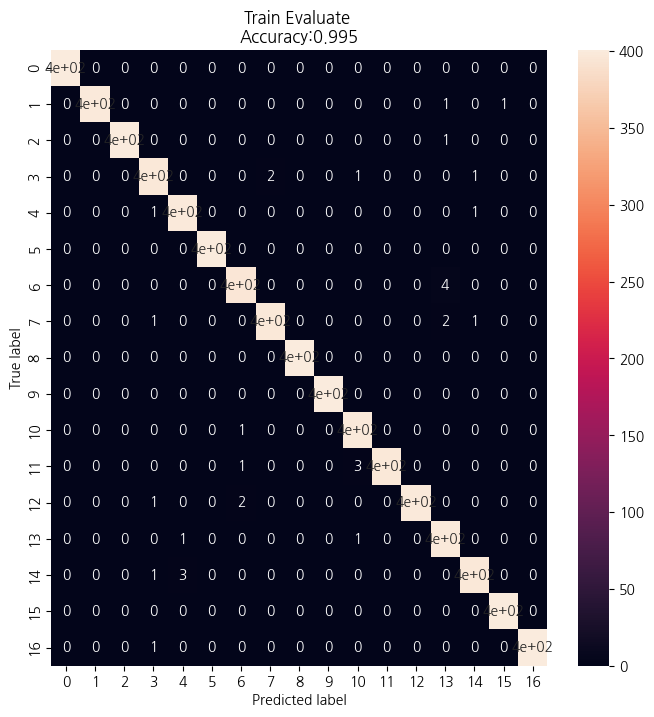

100%|██████████| 107/107 [00:17<00:00,  6.27it/s]


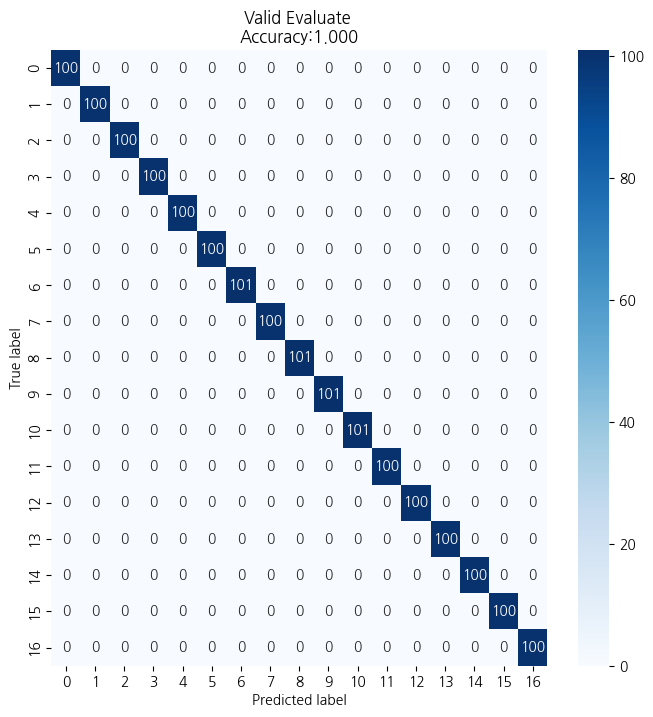

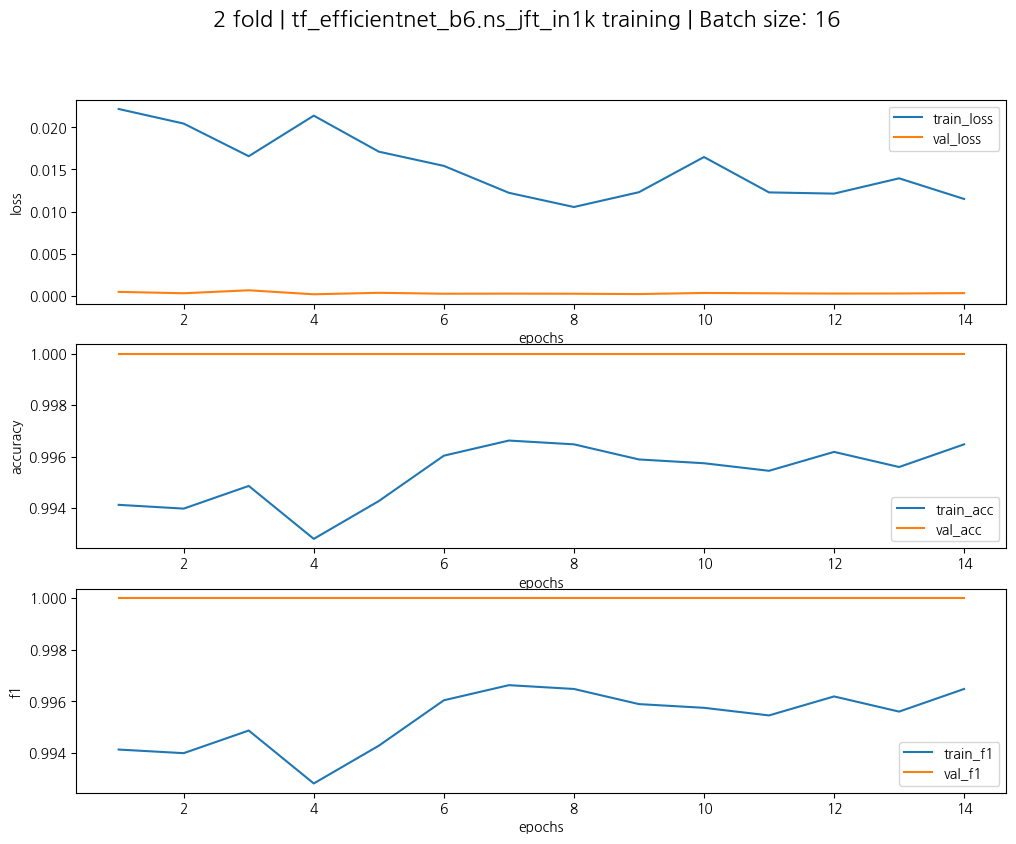

Epoch 1/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.02it/s]



train_loss: 0.0181 train_acc: 0.9938 train_f1: 0.9938 valid_loss: 0.0001 valid_acc: 1.0000 valid_f1: 1.0000 
model saved! tf_efficientnet_b6.ns_jft_in1k_fold2_1.0.pth
best loss update 0.0001
Epoch 2/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:16<00:00,  6.30it/s]



train_loss: 0.0149 train_acc: 0.9959 train_f1: 0.9959 valid_loss: 0.0001 valid_acc: 1.0000 valid_f1: 1.0000 
Epoch 3/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.25it/s]



train_loss: 0.0104 train_acc: 0.9966 train_f1: 0.9966 valid_loss: 0.0001 valid_acc: 1.0000 valid_f1: 1.0000 
model saved! tf_efficientnet_b6.ns_jft_in1k_fold2_1.0.pth
Epoch 4/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.24it/s]



train_loss: 0.0096 train_acc: 0.9965 train_f1: 0.9965 valid_loss: 0.0001 valid_acc: 1.0000 valid_f1: 1.0000 
Epoch 5/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.22it/s]



train_loss: 0.0115 train_acc: 0.9962 train_f1: 0.9962 valid_loss: 0.0001 valid_acc: 1.0000 valid_f1: 1.0000 
Epoch 6/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.22it/s]



train_loss: 0.0133 train_acc: 0.9950 train_f1: 0.9950 valid_loss: 0.0001 valid_acc: 1.0000 valid_f1: 1.0000 
Epoch 7/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.26it/s]



train_loss: 0.0113 train_acc: 0.9955 train_f1: 0.9954 valid_loss: 0.0002 valid_acc: 1.0000 valid_f1: 1.0000 
Epoch 00007: reducing learning rate of group 0 to 7.8125e-06.
Epoch 8/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.14it/s]



train_loss: 0.0090 train_acc: 0.9966 train_f1: 0.9966 valid_loss: 0.0002 valid_acc: 1.0000 valid_f1: 1.0000 
Epoch 9/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.27it/s]



train_loss: 0.0080 train_acc: 0.9978 train_f1: 0.9978 valid_loss: 0.0002 valid_acc: 1.0000 valid_f1: 1.0000 
Epoch 10/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.26it/s]



train_loss: 0.0113 train_acc: 0.9966 train_f1: 0.9966 valid_loss: 0.0001 valid_acc: 1.0000 valid_f1: 1.0000 
Epoch 11/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.19it/s]



train_loss: 0.0077 train_acc: 0.9972 train_f1: 0.9972 valid_loss: 0.0001 valid_acc: 1.0000 valid_f1: 1.0000 
Epoch 12/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.26it/s]



train_loss: 0.0127 train_acc: 0.9960 train_f1: 0.9960 valid_loss: 0.0002 valid_acc: 1.0000 valid_f1: 1.0000 
Epoch 13/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.29it/s]



train_loss: 0.0080 train_acc: 0.9975 train_f1: 0.9975 valid_loss: 0.0001 valid_acc: 1.0000 valid_f1: 1.0000 
Early Stopping counter: 10 out of 10


100%|██████████| 426/426 [01:37<00:00,  4.37it/s]


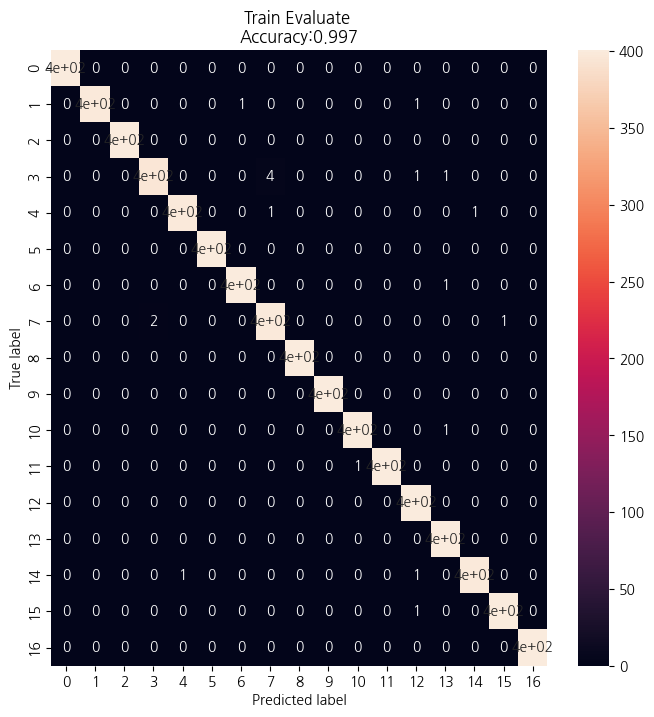

100%|██████████| 107/107 [00:16<00:00,  6.30it/s]


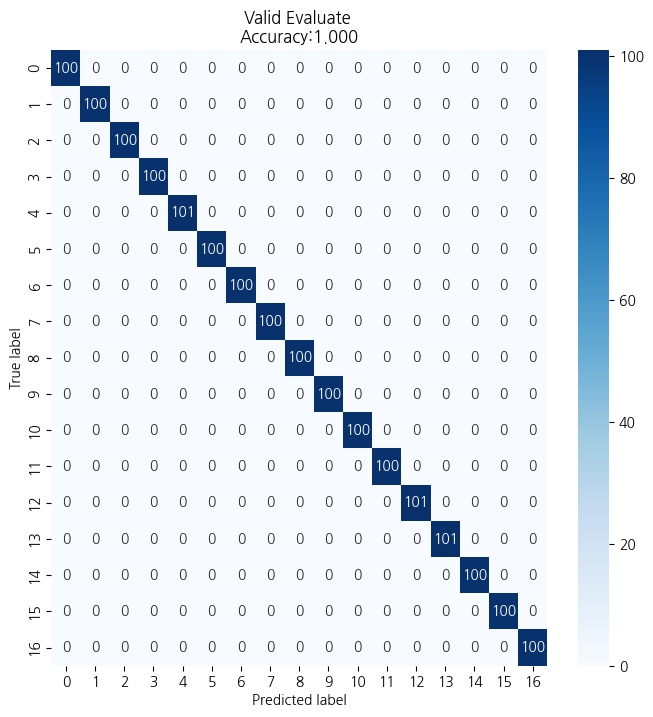

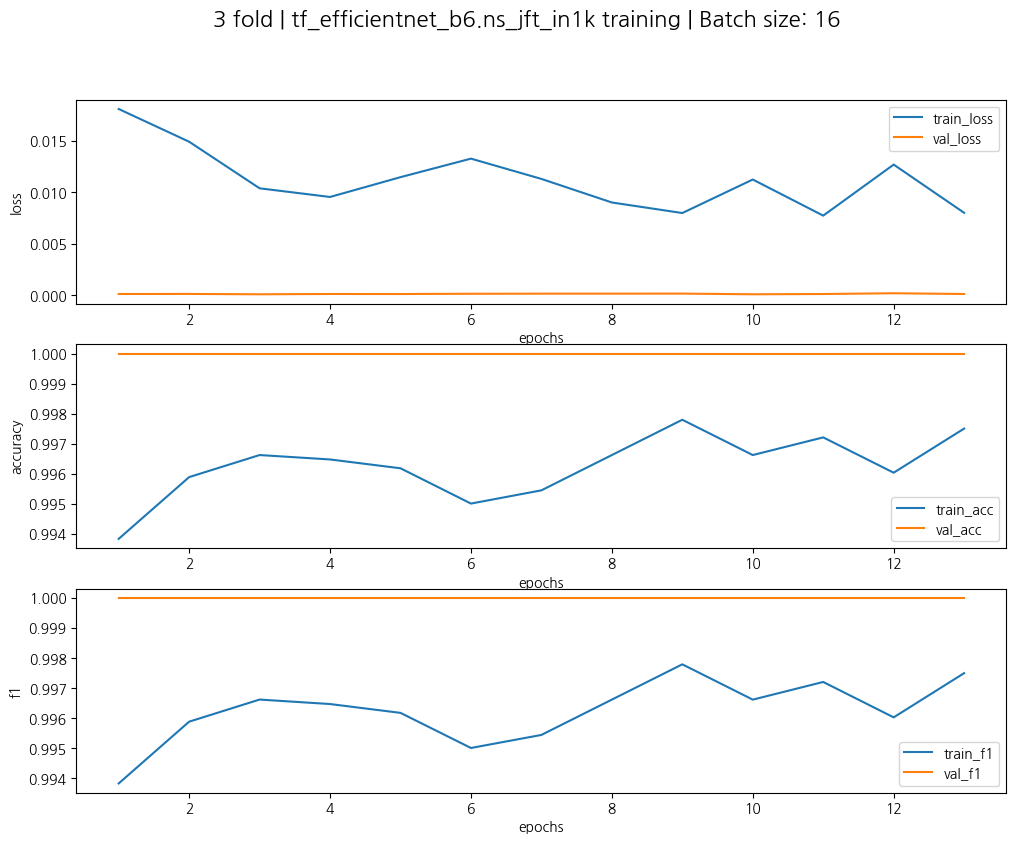

Epoch 1/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:16<00:00,  6.30it/s]



train_loss: 0.0092 train_acc: 0.9975 train_f1: 0.9975 valid_loss: 0.0001 valid_acc: 1.0000 valid_f1: 1.0000 
model saved! tf_efficientnet_b6.ns_jft_in1k_fold3_1.0.pth
best loss update 0.0001
Epoch 2/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.28it/s]



train_loss: 0.0099 train_acc: 0.9966 train_f1: 0.9966 valid_loss: 0.0001 valid_acc: 1.0000 valid_f1: 1.0000 
model saved! tf_efficientnet_b6.ns_jft_in1k_fold3_1.0.pth
Epoch 3/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:16<00:00,  6.37it/s]



train_loss: 0.0100 train_acc: 0.9974 train_f1: 0.9974 valid_loss: 0.0001 valid_acc: 1.0000 valid_f1: 1.0000 
Epoch 4/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.29it/s]



train_loss: 0.0107 train_acc: 0.9968 train_f1: 0.9968 valid_loss: 0.0001 valid_acc: 1.0000 valid_f1: 1.0000 
Epoch 5/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.23it/s]



train_loss: 0.0080 train_acc: 0.9974 train_f1: 0.9974 valid_loss: 0.0001 valid_acc: 1.0000 valid_f1: 1.0000 
Epoch 6/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:16<00:00,  6.30it/s]



train_loss: 0.0094 train_acc: 0.9974 train_f1: 0.9974 valid_loss: 0.0002 valid_acc: 1.0000 valid_f1: 1.0000 
Epoch 7/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.27it/s]



train_loss: 0.0090 train_acc: 0.9975 train_f1: 0.9975 valid_loss: 0.0002 valid_acc: 1.0000 valid_f1: 1.0000 
Epoch 00007: reducing learning rate of group 0 to 3.9063e-06.
Epoch 8/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.26it/s]



train_loss: 0.0105 train_acc: 0.9965 train_f1: 0.9965 valid_loss: 0.0002 valid_acc: 1.0000 valid_f1: 1.0000 
Epoch 9/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.27it/s]



train_loss: 0.0078 train_acc: 0.9979 train_f1: 0.9979 valid_loss: 0.0002 valid_acc: 1.0000 valid_f1: 1.0000 
Epoch 10/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.25it/s]



train_loss: 0.0122 train_acc: 0.9965 train_f1: 0.9965 valid_loss: 0.0002 valid_acc: 1.0000 valid_f1: 1.0000 
Epoch 11/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.22it/s]



train_loss: 0.0109 train_acc: 0.9955 train_f1: 0.9954 valid_loss: 0.0002 valid_acc: 1.0000 valid_f1: 1.0000 
Epoch 12/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.23it/s]



train_loss: 0.0104 train_acc: 0.9962 train_f1: 0.9962 valid_loss: 0.0002 valid_acc: 1.0000 valid_f1: 1.0000 
Early Stopping counter: 10 out of 10


100%|██████████| 426/426 [01:36<00:00,  4.42it/s]


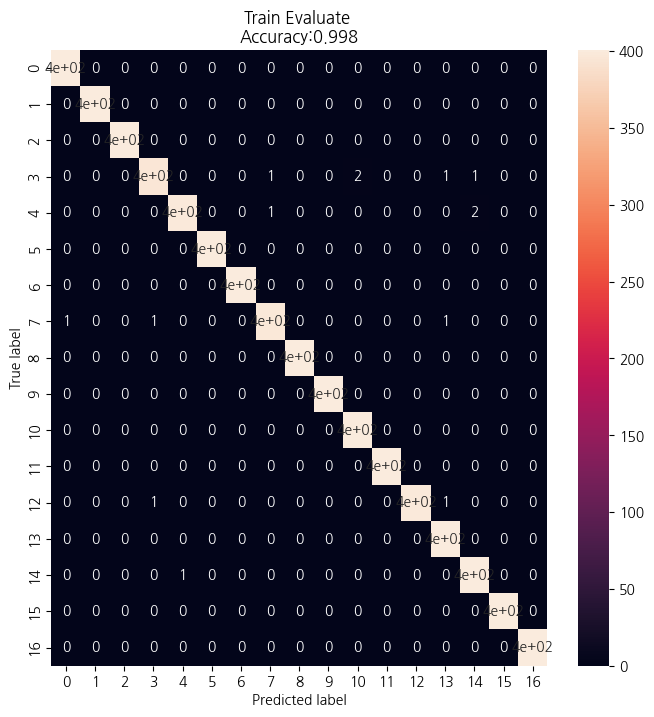

100%|██████████| 107/107 [00:17<00:00,  6.19it/s]


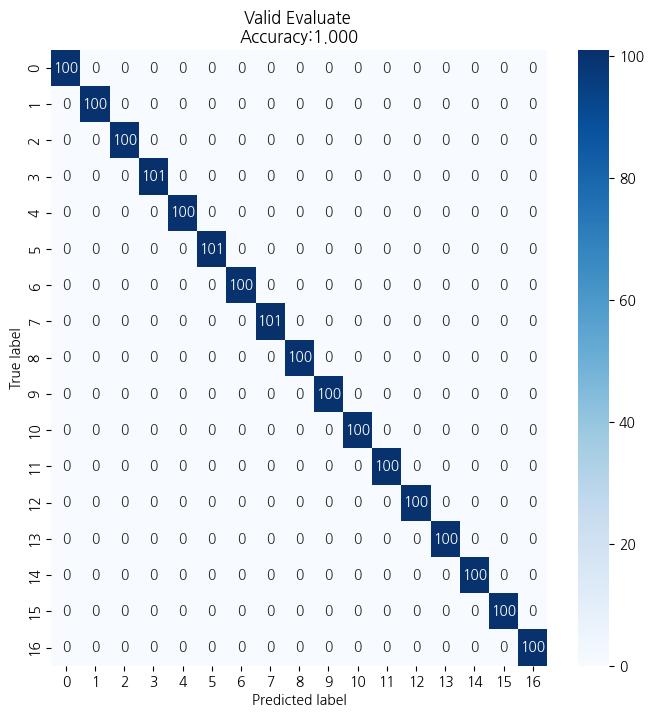

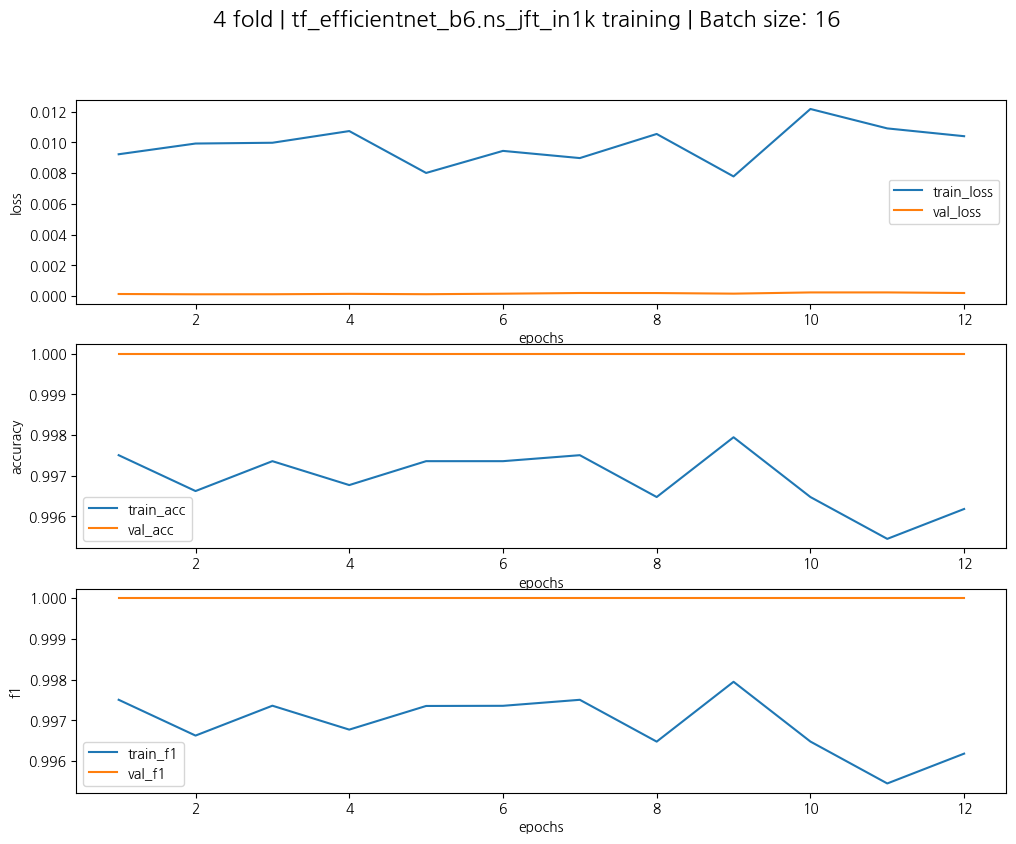

Epoch 1/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.26it/s]



train_loss: 0.0117 train_acc: 0.9960 train_f1: 0.9960 valid_loss: 0.0007 valid_acc: 1.0000 valid_f1: 1.0000 
model saved! tf_efficientnet_b6.ns_jft_in1k_fold4_1.0.pth
best loss update 0.0007
Epoch 2/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.22it/s]



train_loss: 0.0083 train_acc: 0.9977 train_f1: 0.9977 valid_loss: 0.0007 valid_acc: 1.0000 valid_f1: 1.0000 
Epoch 3/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.22it/s]



train_loss: 0.0083 train_acc: 0.9977 train_f1: 0.9977 valid_loss: 0.0007 valid_acc: 1.0000 valid_f1: 1.0000 
Epoch 4/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:16<00:00,  6.33it/s]



train_loss: 0.0137 train_acc: 0.9957 train_f1: 0.9957 valid_loss: 0.0006 valid_acc: 1.0000 valid_f1: 1.0000 
model saved! tf_efficientnet_b6.ns_jft_in1k_fold4_1.0.pth
Epoch 5/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.16it/s]



train_loss: 0.0095 train_acc: 0.9969 train_f1: 0.9969 valid_loss: 0.0010 valid_acc: 1.0000 valid_f1: 1.0000 
Epoch 6/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.23it/s]



train_loss: 0.0088 train_acc: 0.9969 train_f1: 0.9969 valid_loss: 0.0007 valid_acc: 1.0000 valid_f1: 1.0000 
Epoch 7/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:16<00:00,  6.30it/s]



train_loss: 0.0123 train_acc: 0.9955 train_f1: 0.9955 valid_loss: 0.0009 valid_acc: 1.0000 valid_f1: 1.0000 
Epoch 00007: reducing learning rate of group 0 to 1.9531e-06.
Epoch 8/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.15it/s]



train_loss: 0.0136 train_acc: 0.9959 train_f1: 0.9959 valid_loss: 0.0008 valid_acc: 1.0000 valid_f1: 1.0000 
Epoch 9/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:16<00:00,  6.36it/s]



train_loss: 0.0098 train_acc: 0.9972 train_f1: 0.9972 valid_loss: 0.0010 valid_acc: 0.9994 valid_f1: 0.9994 
Epoch 10/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.20it/s]



train_loss: 0.0084 train_acc: 0.9971 train_f1: 0.9971 valid_loss: 0.0010 valid_acc: 1.0000 valid_f1: 1.0000 
Epoch 11/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.27it/s]



train_loss: 0.0109 train_acc: 0.9968 train_f1: 0.9968 valid_loss: 0.0009 valid_acc: 1.0000 valid_f1: 1.0000 
Epoch 12/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:16<00:00,  6.30it/s]



train_loss: 0.0105 train_acc: 0.9960 train_f1: 0.9960 valid_loss: 0.0009 valid_acc: 1.0000 valid_f1: 1.0000 
Epoch 13/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.25it/s]



train_loss: 0.0120 train_acc: 0.9957 train_f1: 0.9957 valid_loss: 0.0010 valid_acc: 1.0000 valid_f1: 1.0000 
Epoch 00013: reducing learning rate of group 0 to 9.7656e-07.
Epoch 14/50


Valid Loss: 0.0000: 100%|██████████| 107/107 [00:17<00:00,  6.20it/s]



train_loss: 0.0081 train_acc: 0.9974 train_f1: 0.9974 valid_loss: 0.0009 valid_acc: 1.0000 valid_f1: 1.0000 
Early Stopping counter: 10 out of 10


100%|██████████| 426/426 [01:36<00:00,  4.43it/s]


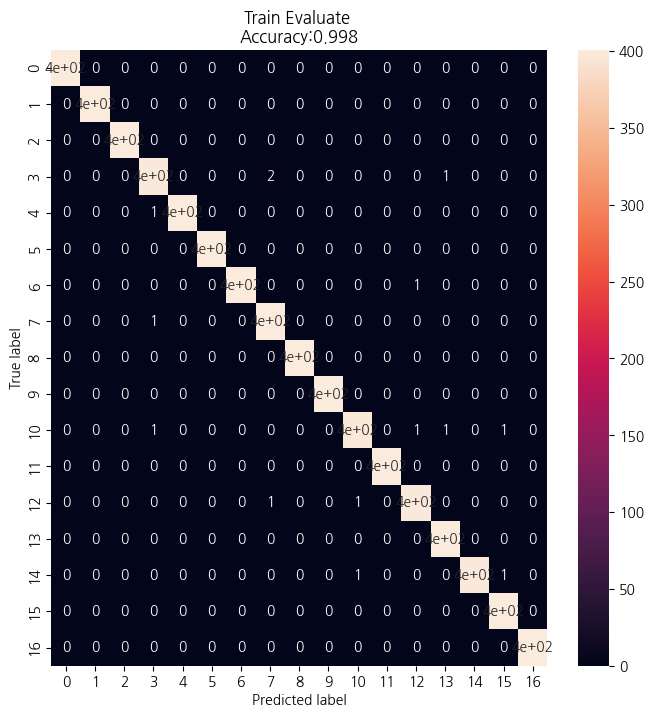

100%|██████████| 107/107 [00:17<00:00,  6.27it/s]


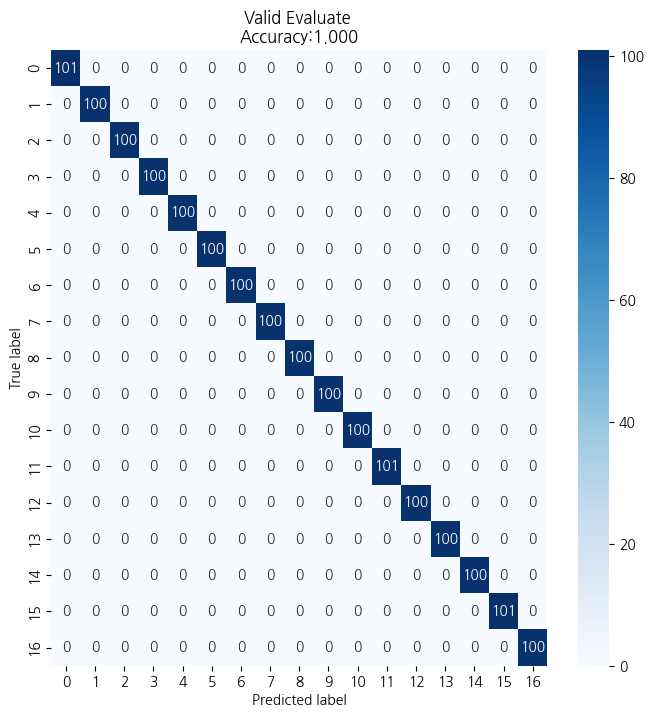

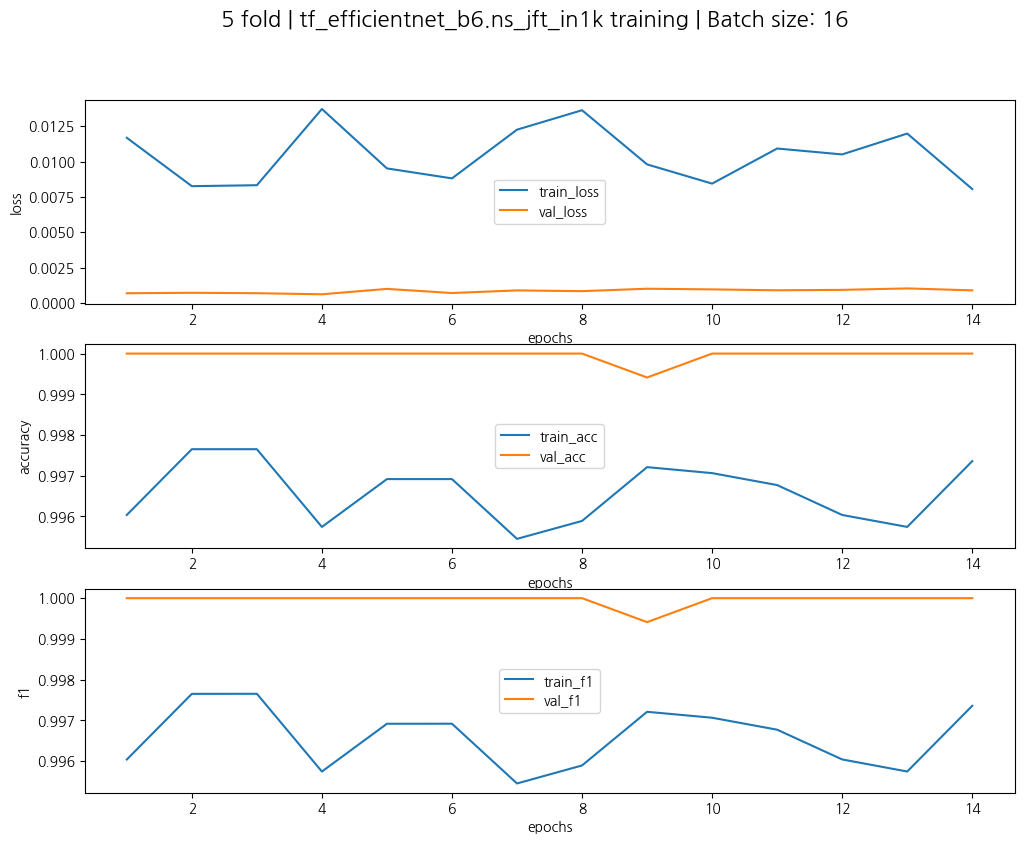

In [45]:
skf = StratifiedKFold(n_splits=args.kfolds, shuffle=True, random_state=args.seed)
target = train_total["target"]

for fold, (train_idx, val_idx) in enumerate(skf.split(train_total, target)):
    train_df = train_total.iloc[train_idx]
    valid_df = train_total.iloc[val_idx]
    
    #print(train_df.shape, valid_df.shape)

    best_model_path, log, score = run(model, fold, train_df, valid_df, test)

    plot_cm(best_model_path, train_df, valid_df)

    visualize_training_results(score['train_loss'],
                               score['valid_loss'],
                               score['train_acc'],
                               score['valid_acc'],
                               score['train_f1'],
                               score['valid_f1'],
                               score['epoch'] + 1,
                               fold + 1)    
    
    if args.single_fold:
        break 
       
writer.close()    

# 6. Inference & Save File
* 테스트 이미지에 대한 추론을 진행하고, 결과 파일을 저장합니다.

In [46]:
# preds_list = []

# model.eval()
# for image, _ in tqdm(tst_loader):
#     image = image.to(device)

#     with torch.no_grad():
#         preds = model(image)
#     preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())

In [47]:
# pred_df = pd.DataFrame(tst_dataset.df, columns=['ID', 'target'])
# pred_df['target'] = preds_list

In [48]:
# sample_submission_df = pd.read_csv("data/sample_submission.csv")
# assert (sample_submission_df['ID'] == pred_df['ID']).all()

In [49]:
# Best Param 기록
now = time.localtime()
filename = time.strftime('%Y%m%d%H%M%S', now)

#pred_df.to_csv(f"output/pred_{filename}.csv", index=False)

In [50]:
#pred_df.head()

In [51]:
# Best Param 기록
condition = '''num_workers = 64
    조건 기존과 동일 클래스당 500개 이미지로 조정 
    Early Stopping counter를 15회에서 10회로 조정
    소요시간 : ? (Early Stopping때문에 빨리 학습이 종료됨) 
    ensemble model 결과 적용 
'''
with open('output/BestParam.log', 'a') as file:
    file.write("\n1. Date : %s\n" % filename)
    file.write("2. Model : %s\n" % args.model)
    file.write("3. Condition : %s\n" % condition)
    file.write(f"4. params : epochs [{args.n_epochs}], LR [{args.lr}], BATCH_SIZE [{args.batch_size}]\n")
    file.write("5. Score: %s\n" % log)


In [52]:
def save_output(model_path, filename):
    torch.cuda.empty_cache()
    gc.collect()

    preds_list = []

    model = torch.load(model_path).to(config["device"])
    model.eval()

    for image, _ in tqdm(tst_loader):
        image = image.to(device)

        with torch.no_grad():
            preds = model(image)
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())

    print(len(preds_list))
    print(f'best model : {model_path}')

    pred_df = pd.DataFrame(tst_dataset.df, columns=['ID', 'target'])
    pred_df['target'] = preds_list

    sample_submission_df = pd.read_csv("data/sample_submission.csv")
    assert (sample_submission_df['ID'] == pred_df['ID']).all()

    pred_df.to_csv(f"output/pred_{filename}_{args.model}_final.csv", index=False)

In [53]:
save_output(best_model_path, filename)

  0%|          | 0/99 [00:00<?, ?it/s]

100%|██████████| 99/99 [00:46<00:00,  2.14it/s]

3140
best model : results/tf_efficientnet_b6.ns_jft_in1k/best_model_4.pth


In [54]:
import ttach as tta

class Ensemble:
    def __init__(self, model_paths, tst_loader):
        self.model_paths = model_paths
        self.tst_loader = tst_loader
        
    def predict(self):
        results = []
    
        for model_path in tqdm(self.model_paths):
            torch.cuda.empty_cache()
            gc.collect()
            
            result = []
            model = torch.load(model_path).to(args.device)
            
            tta_model = tta.ClassificationTTAWrapper(model, tta.aliases.d4_transform())
            tta_model.eval()
            
            for image, _ in tqdm(tst_loader):
                image = image.to(device)

                with torch.no_grad():
                    preds = model(image)
                result.extend(preds.argmax(dim=1).detach().cpu().numpy())

            results.append(np.array(result))
            
        return results

In [55]:
def save_output2(filename, tst_loader, tst_dataset):
    torch.cuda.empty_cache()
    gc.collect()

    model_paths = ["results/tf_efficientnet_b6.ns_jft_in1k/best_model_0.pth",
                    "results/tf_efficientnet_b6.ns_jft_in1k/best_model_1.pth",
                    "results/tf_efficientnet_b6.ns_jft_in1k/best_model_2.pth", 
                    "results/tf_efficientnet_b6.ns_jft_in1k/best_model_3.pth",
                    "results/tf_efficientnet_b6.ns_jft_in1k/best_model_4.pth"]

    ensemble_models = Ensemble(model_paths, tst_loader)    
    preds = ensemble_models.predict()
    print(len(preds))

    preds_max = list(stats.mode(np.array(preds), axis=0)[0])
    answer_df = pd.DataFrame({'target' : preds_max})

    pred_df = pd.DataFrame(tst_dataset.df, columns=['ID', 'target'])
    pred_df['target'] = answer_df['target']

    sample_submission_df = pd.read_csv("data/sample_submission.csv")
    assert (sample_submission_df['ID'] == pred_df['ID']).all()

    pred_df.to_csv(f"output/pred_{filename}_{args.model}_ensemble.csv", index=False)      


In [56]:
save_output2(filename, tst_loader, tst_dataset)

100%|██████████| 5/5 [03:45<00:00, 45.12s/it]

5


In [57]:
def save_output3(filename, tst_loader, tst_dataset):
    torch.cuda.empty_cache()
    gc.collect()

    model_paths = ["results/efficientnet_b5/best_model_0.pth",
                    "results/efficientnet_b5/best_model_1.pth",
                    "results/efficientnet_b5/best_model_2.pth", 
                    "results/efficientnet_b5/best_model_3.pth",
                    "results/efficientnet_b5/best_model_4.pth",
                    "results/tf_efficientnet_b6.ns_jft_in1k/best_model_0.pth",
                    "results/tf_efficientnet_b6.ns_jft_in1k/best_model_1.pth",
                    "results/tf_efficientnet_b6.ns_jft_in1k/best_model_2.pth", 
                    "results/tf_efficientnet_b6.ns_jft_in1k/best_model_3.pth",
                    "results/tf_efficientnet_b6.ns_jft_in1k/best_model_4.pth",
                    "results/tf_efficientnet_b7.ns_jft_in1k/best_model_0.pth",
                    "results/tf_efficientnet_b7.ns_jft_in1k/best_model_1.pth",
                    "results/tf_efficientnet_b7.ns_jft_in1k/best_model_2.pth", 
                    "results/tf_efficientnet_b7.ns_jft_in1k/best_model_3.pth",
                    "results/tf_efficientnet_b7.ns_jft_in1k/best_model_4.pth"]

    ensemble_models = Ensemble(model_paths, tst_loader)    
    preds = ensemble_models.predict()
    print(len(preds))

    preds_max = list(stats.mode(np.array(preds), axis=0)[0])
    answer_df = pd.DataFrame({'target' : preds_max})

    pred_df = pd.DataFrame(tst_dataset.df, columns=['ID', 'target'])
    pred_df['target'] = answer_df['target']

    sample_submission_df = pd.read_csv("data/sample_submission.csv")
    assert (sample_submission_df['ID'] == pred_df['ID']).all()

    pred_df.to_csv(f"output/pred_{filename}_total.csv", index=False)  

In [58]:
save_output3(filename, tst_loader, tst_dataset)

100%|██████████| 15/15 [11:22<00:00, 45.48s/it]

15
